# Overview

This notebook contains my solutions for **<a href="https://adventofcode.com/2023" target="_blank">Advent of Code 2023</a>**.

A few notes...
- The source for this notebook source lives in my GitHub repo, <a href="https://github.com/derailed-dash/Advent-of-Code/blob/master/src/AoC_2023/Dazbo's_Advent_of_Code_2023.ipynb" target="_blank">here</a>.
- You can run this Notebook wherever you like. For example, you could...
  - Run it locally, in your own Jupyter environment.
  - Run it in a cloud-based Jupyter environment, with no setup required on your part!  For example, <a href="https://colab.research.google.com/github/derailed-dash/Advent-of-Code/blob/master/src/AoC_2023/Dazbo's_Advent_of_Code_2023.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Google Colab"/></a>
- **To run the notebook, execute the cells in the [Setup](#Setup) section, as described below. Then you can run the code for any given day.**
- Be mindful that the first time you run this notebook, you will need to **obtain your AoC session key** and store it, if you have not done so already. This allows the notebook to automatically retrieve your input data. (See the guidance in the **[Get Access to Your AoC Data](#Get-Access-to-Your-AoC-Data)** section for details.)
- Use the navigation menu on the left to jump to any particular day.
- All of my AoC solutions are documented in my <a href="https://aoc.just2good.co.uk/" target="_blank">AoC Python Walkthrough site</a>.

# Setup

You need to run all cells in this section, before running any particular day solution.

## Packages and Imports

Here we use `pip` to install the packages used by my solutions in this event.

In [1]:
%pip install jupyterlab-lsp colorama python-dotenv ipykernel 

Note: you may need to restart the kernel to use updated packages.


In [175]:
from __future__ import annotations
from dataclasses import asdict, dataclass, field
from enum import Enum, auto
from functools import cache, reduce
from itertools import permutations, combinations, count, cycle
from collections import Counter, deque, defaultdict
import heapq
import copy
import operator
import logging
import time
import os
import re
import ast
import unittest
import requests
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import path as pltpath
import numpy as np
import networkx as nx
import pandas as pd
from tqdm.notebook import tqdm
from dotenv import load_dotenv
from pathlib import Path
from getpass import getpass
from colorama import Fore, Back, Style
from IPython.display import display
from IPython.core.display import Markdown

## Logging and Output

Set up a new logger that uses `ColouredFormatter`, such that we have coloured logging.  The log colour depends on the logging level.

In [3]:
##########################################################################
# SETUP LOGGING
#
# Create a new instance of "logger" in the client application
# Set to your preferred logging level
# And add the stream_handler from this module, if you want coloured output
##########################################################################

# logger for aoc_commons only
logger = logging.getLogger(__name__) # aoc_common.aoc_commons
logger.setLevel(logging.INFO)
stream_handler = None

class ColouredFormatter(logging.Formatter):
    """ Custom Formater which adds colour to output, based on logging level """

    level_mapping = {"DEBUG": (Fore.BLUE, "DBG"),
                     "INFO": (Fore.GREEN, "INF"),
                     "WARNING": (Fore.YELLOW, "WRN"),
                     "ERROR": (Fore.RED, "ERR"),
                     "CRITICAL": (Fore.MAGENTA, "CRT")
    }

    def __init__(self, *args, apply_colour=True, shorten_lvl=True, **kwargs) -> None:
        """ Args:
            apply_colour (bool, optional): Apply colouring to messages. Defaults to True.
            shorten_lvl (bool, optional): Shorten level names to 3 chars. Defaults to True.
        """
        super().__init__(*args, **kwargs)
        self._apply_colour = apply_colour
        self._shorten_lvl = shorten_lvl

    def format(self, record):
        if record.levelname in ColouredFormatter.level_mapping:
            new_rec = copy.copy(record)
            colour, new_level = ColouredFormatter.level_mapping[record.levelname]

            if self._shorten_lvl:
                new_rec.levelname = new_level

            if self._apply_colour:
                msg = colour + super().format(new_rec) + Fore.RESET
            else:
                msg = super().format(new_rec)

            return msg

        # If our logging message is not using one of these levels...
        return super().format(record)

if not stream_handler:
    stream_handler = logging.StreamHandler()
    stream_fmt = ColouredFormatter(fmt='%(asctime)s.%(msecs)03d:%(name)s - %(levelname)s: %(message)s',
                                   datefmt='%H:%M:%S')
    stream_handler.setFormatter(stream_fmt)
    
if not logger.handlers:
    # Add our ColouredFormatter as the default console logging
    logger.addHandler(stream_handler)

def retrieve_console_logger(script_name):
    """ Create and return a new logger, named after the script
    So, in your calling code, add a line like this:
    logger = ac.retrieve_console_logger(locations.script_name)
    """
    a_logger = logging.getLogger(script_name)
    a_logger.addHandler(stream_handler)
    a_logger.propagate = False
    return a_logger

def setup_file_logging(a_logger: logging.Logger, folder: str|Path=""):
    """ Add a FileHandler to the specified logger. File name is based on the logger name.
    In calling code, we can add a line like this:
    td.setup_file_logging(logger, locations.output_dir)

    Args:
        a_logger (Logger): The existing logger
        folder (str): Where the log file will be created. Will be created if it doesn't exist
    """
    Path(folder).mkdir(parents=True, exist_ok=True)     # Create directory if it does not exist
    file_handler = logging.FileHandler(Path(folder, a_logger.name + ".log"), mode='w')
    file_fmt = logging.Formatter(fmt="%(asctime)s.%(msecs)03d:%(name)s:%(levelname)8s: %(message)s",
                                datefmt='%H:%M:%S')
    file_handler.setFormatter(file_fmt)
    a_logger.addHandler(file_handler)

In [4]:
def top_and_tail(data, block_size=5, include_line_numbers=True, zero_indexed=False):
    """ Print a summary of a large amount of data 

    Args:
        data (_type_): The data to present in summary form.
        block_size (int, optional): How many rows to include in the top, and in the tail.
        include_line_numbers (bool, optional): Prefix with line number. Defaults to True.
        zero_indexed (bool, optional): Lines start at 0? Defaults to False.
    """
    if isinstance(data, list):
        # Get the number of digits of the last item for proper alignment
        num_digits_last_item = len(str(len(data)))

        # Format the string with line number
        def format_with_line_number(idx, line):
            start = 0 if zero_indexed else 1
            if include_line_numbers:
                return f"{idx + start:>{num_digits_last_item}}: {line}"
            else:
                return line

        start = 0 if zero_indexed else 1
        if len(data) < 11:
            return "\n".join(format_with_line_number(i, line) for i, line in enumerate(data))
        else:
            top = [format_with_line_number(i, line) for i, line in enumerate(data[:block_size])]
            tail = [format_with_line_number(i, line) for i, line in enumerate(data[-block_size:], start=len(data)-block_size)]
            return "\n".join(top + ["..."] + tail)
    else:
        return data

## Get Access to Your AoC Data

Now provide your unique AoC session key, in order to download your input data. You can get this by:
1. Logging into [Advent of Code](https://adventofcode.com/).
1. From your browser, open Developer Tools. (In Chrome, you can do this by pressing F12.)
1. Open the `Application` tab.
1. Storage -> Cookies -> https://adventofcode.com
1. Copy the value associated with the cookie called `session`.
1. Once you've determiend your session key, I recommend you store it in a file called `.env`, in your `Advent-of-Code` folder, like this: \
`AOC_SESSION_COOKIE=536...your-own-session-key...658` \
This notebook will try to retrieve the key from that location.  If it is unable to retrieve the key, it will prompt you to enter your key in the cell below.

![Finding the session cookie](https://aoc.just2good.co.uk/assets/images/aoc-cookie.png)



In [5]:
def get_envs_from_file() -> bool:
    """ Look for .env files, read variables from it, and store as environment variables """
    potential_path = ".env"
    for _ in range(3):
        logger.debug("Trying .env at %s", os.path.realpath(potential_path))
        if os.path.exists(potential_path):
            logger.info("Using .env at %s", os.path.realpath(potential_path))
            load_dotenv(potential_path, verbose=True)
            return True
        
        potential_path = os.path.join('..', potential_path)
   
    logger.warning("No .env file found.")
    return False

get_envs_from_file() # read env variables from a .env file, if we can find one

16:20:40.793:__main__ - INF: Using .env at F:\Users\Darren\localdev\Python\Advent-of-Code\.env


True

In [6]:
if os.getenv('AOC_SESSION_COOKIE'):
    logger.info('Session cookie retrieved: %s...%s', os.environ['AOC_SESSION_COOKIE'][0:6], os.environ['AOC_SESSION_COOKIE'][-6:])
else: # it's not in our environment variables, so we'll need to input the value
    os.environ['AOC_SESSION_COOKIE'] = getpass('Enter AoC session key: ')

16:20:40.803:__main__ - INF: Session cookie retrieved: 53616c...13d33c


## Load Helpers and Useful Classes

Now we load a bunch of helper functions and classes.

### Locations

Where any input and output files get stored.

<img src="https://aoc.just2good.co.uk/assets/images/notebook-content-screenshot.png" width="320" />


In [7]:
#################################################################
# Paths and Locations
#################################################################

@dataclass
class Locations:
    """ Dataclass for storing various location properties """
    script_name: str
    script_dir: Path
    input_dir: Path
    output_dir: Path
    input_file: Path

def get_locations(script_name, folder="") -> Locations:
    """ Set various paths, based on the location of the calling script. """
    current_directory = os.getcwd()
    script_dir = Path(Path().resolve(), folder, script_name)
    input_dir = Path(script_dir, "input")
    output_dir = Path(script_dir, "output")
    input_file = Path(input_dir, "input.txt")

    return Locations(script_name, script_dir,
                     input_dir,
                     output_dir,
                     input_file)

### Retrieve the Input Data

This works by using your unique session cookie to retrieve your input data. E.g. from a URL like:

`https://adventofcode.com/2015/day/1/input`

In [8]:
##################################################################
# Retrieving input data
##################################################################

def write_puzzle_input_file(year: int, day, locations: Locations):
    """ Use session key to obtain user's unique data for this year and day.
    Only retrieve if the input file does not already exist.
    Return True if successful.
    Requires env: AOC_SESSION_COOKIE, which can be set from the .env.
    """
    if os.path.exists(locations.input_file):
        logger.debug("%s already exists", os.path.basename(locations.input_file))
        return os.path.basename(locations.input_file)

    session_cookie = os.getenv('AOC_SESSION_COOKIE')
    if not session_cookie:
        raise ValueError("Could not retrieve session cookie.")

    logger.info('Session cookie retrieved: %s...%s', session_cookie[0:6], session_cookie[-6:])

    # Create input folder, if it doesn't exist
    if not locations.input_dir.exists():
        locations.input_dir.mkdir(parents=True, exist_ok=True)

    url = f"https://adventofcode.com/{year}/day/{day}/input"
    
    # Don't think we need to set a user-agent
    # headers = {
    #     "User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'
    # }
    cookies = { 
        "session": session_cookie
    }
    response = requests.get(url, cookies=cookies, timeout=5)

    data = ""
    if response.status_code == 200:
        data = response.text

        with open(locations.input_file, 'w') as file:
            logger.debug("Writing input file %s", os.path.basename(locations.input_file))
            file.write(data)
            return data
    else:
        raise ValueError(f"Unable to retrieve input data.\n" +
                         f"HTTP response: {response.status_code}\n" +
                         f"{response.reason}: {response.content.decode('utf-8').strip()}")


### Testing

A really simple function for testing that our solution produces the expected test output.

In [9]:
def validate(test, answer):
    """
    Args:
        test: the answer given by our solution
        answer: the expected answer, e.g. from instructions
    """
    if test != answer:
        raise AssertionError(f"{test} != {answer}")

### Useful Helper Classes

In [10]:
#################################################################
# POINTS, VECTORS AND GRIDS
#################################################################

@dataclass(frozen=True)
class Point:
    """ Class for storing a point x,y coordinate """
    x: int
    y: int

    def __add__(self, other: Point):
        return Point(self.x + other.x, self.y + other.y)

    def __mul__(self, other: Point):
        """ (x, y) * (a, b) = (xa, yb) """
        return Point(self.x * other.x, self.y * other.y)

    def __sub__(self, other: Point):
        return self + Point(-other.x, -other.y)

    def __lt__(self, other):
        # Arbitrary comparison logic
        return (self.x, self.y) < (other.x, other.y)
    
    def yield_neighbours(self, include_diagonals=True, include_self=False):
        """ Generator to yield neighbouring Points """

        deltas: list
        if not include_diagonals:
            deltas = [vector.value for vector in Vectors if abs(vector.value[0]) != abs(vector.value[1])]
        else:
            deltas = [vector.value for vector in Vectors]

        if include_self:
            deltas.append((0, 0))

        for delta in deltas:
            yield Point(self.x + delta[0], self.y + delta[1])

    def neighbours(self, include_diagonals=True, include_self=False) -> list[Point]:
        """ Return all the neighbours, with specified constraints.
        They are returned clockwise, starting with N.
        It wraps the generator with a list. """
        return list(self.yield_neighbours(include_diagonals, include_self))

    def get_specific_neighbours(self, directions: list[Vectors]) -> list[Point]:
        """ Get neighbours, given a specific list of allowed locations. """
        return [(self + Point(*vector.value)) for vector in list(directions)]

    @staticmethod
    def manhattan_distance(a_point: Point) -> int:
        """ Return the Manhattan distance value of this vector """
        return sum(abs(coord) for coord in asdict(a_point).values())

    def manhattan_distance_from(self, other: Point) -> int:
        """ Manhattan distance between this Vector and another Vector """
        diff = self-other
        return Point.manhattan_distance(diff)

    def __repr__(self):
        return f"P({self.x},{self.y})"

class Vectors(Enum):
    """ Enumeration of 8 directions.
    Note: y axis increments in the North direction, i.e. N = (0, 1) """
    N = (0, 1)
    NE = (1, 1)
    E = (1, 0)
    SE = (1, -1)
    S = (0, -1)
    SW = (-1, -1)
    W = (-1, 0)
    NW = (-1, 1)

    @property
    def y_inverted(self):
        """ Return vector, but with y-axis inverted. I.e. N = (0, -1) """
        x, y = self.value
        inverted_value = (x, -y)
        
        # Find the corresponding vector with the inverted value
        for vector in Vectors:
            if vector.value == inverted_value:
                return vector

class VectorDicts():
    """ Contains constants for Vectors """
    ARROWS = {
        '^': Vectors.N.value,
        '>': Vectors.E.value,
        'v': Vectors.S.value,
        '<': Vectors.W.value
    }

    DIRS = {
        'U': Vectors.N.value,
        'R': Vectors.E.value,
        'D': Vectors.S.value,
        'L': Vectors.W.value
    }

    NINE_BOX: dict[str, tuple[int, int]] = {
        # x, y vector for adjacent locations
        'tr': (1, 1),
        'mr': (1, 0),
        'br': (1, -1),
        'bm': (0, -1),
        'bl': (-1, -1),
        'ml': (-1, 0),
        'tl': (-1, 1),
        'tm': (0, 1)
    }

class Grid():
    """ 2D grid of point values. """
    def __init__(self, grid_array: list) -> None:
        self._array = grid_array
        self._width = len(self._array[0])
        self._height = len(self._array)

    def value_at_point(self, point: Point):
        """ The value at this point """
        return self._array[point.y][point.x]

    def set_value_at_point(self, point: Point, value):
        if isinstance(self._array[0], str):
            row = self._array[point.y]
            self._array[point.y] = row[:point.x] + value + row[point.x + 1:]
        else: # assume we have a replaceable type, like list[int]
            self._array[point.y][point.x] = value

    def valid_location(self, point: Point) -> bool:
        """ Check if a location is within the grid """
        if (0 <= point.x < self._width and  0 <= point.y < self._height):
            return True

        return False

    @property
    def width(self):
        """ Array width (cols) """
        return self._width

    @property
    def height(self):
        """ Array height (rows) """
        return self._height

    def all_points(self) -> list[Point]:
        points = [Point(x, y) for x in range(self.width) for y in range(self.height)]
        return points

    def rows_as_str(self):
        """ Return the grid """
        return ["".join(str(char) for char in row) for row in self._array]

    def cols_as_str(self):
        """ Render columns as str. Returns: list of str """
        cols_list = list(zip(*self._array))
        return ["".join(str(char) for char in col) for col in cols_list]

    def __repr__(self) -> str:
        return f"Grid(size={self.width}*{self.height})"

    def __str__(self) -> str:
        return "\n".join("".join(map(str, row)) for row in self._array)

### Useful Helper Functions

In [11]:
#################################################################
# CONSOLE STUFF
#################################################################

def cls():
    """ Clear console """
    os.system('cls' if os.name=='nt' else 'clear')

#################################################################
# USEFUL FUNCTIONS
#################################################################

def binary_search(target, low:int, high:int, func, *func_args, reverse_search=False):
    """ Generic binary search function that takes a target to find,
    low and high values to start with, and a function to run, plus its args.
    Implicitly returns None if the search is exceeded. """

    res = None  # just set it to something that isn't the target
    candidate = 0  # initialise; we'll set it to the mid point in a second

    while low < high:  # search exceeded
        candidate = int((low+high) // 2)  # pick mid-point of our low and high
        res = func(candidate, *func_args) # run our function, whatever it is
        logger.debug("%d -> %d", candidate, res)
        if res == target:
            return candidate  # solution found

        comp = operator.lt if not reverse_search else operator.gt
        if comp(res, target):
            low = candidate
        else:
            high = candidate

def merge_intervals(intervals: list[list]) -> list[list]:
    """ Takes intervals in the form [[a, b][c, d][d, e]...]
    Intervals can overlap.  Compresses to minimum number of non-overlapping intervals. """
    intervals.sort()
    stack = []
    stack.append(intervals[0])

    for interval in intervals[1:]:
        # Check for overlapping interval
        if stack[-1][0] <= interval[0] <= stack[-1][-1]:
            stack[-1][-1] = max(stack[-1][-1], interval[-1])
        else:
            stack.append(interval)

    return stack

@cache
def get_factors(num: int) -> set[int]:
    """ Gets the factors for a given number. Returns a set[int] of factors.
        # E.g. when num=8, factors will be 1, 2, 4, 8 """
    factors = set()

    # Iterate from 1 to sqrt of 8,
    # since a larger factor of num must be a multiple of a smaller factor already checked
    for i in range(1, int(num**0.5) + 1):  # e.g. with num=8, this is range(1, 3)
        if num % i == 0: # if it is a factor, then dividing num by it will yield no remainder
            factors.add(i)  # e.g. 1, 2
            factors.add(num//i)  # i.e. 8//1 = 8, 8//2 = 4

    return factors

def to_base_n(number: int, base: int):
    """ Convert any integer number into a base-n string representation of that number.
    E.g. to_base_n(38, 5) = 123

    Args:
        number (int): The number to convert
        base (int): The base to apply

    Returns:
        [str]: The string representation of the number
    """
    ret_str = ""
    curr_num = number
    while curr_num:
        ret_str = str(curr_num % base) + ret_str
        curr_num //= base

    return ret_str if number > 0 else "0"


### Generic Initialisation


In [12]:
FOLDER = "aoc"
YEAR = 2023
logger_identifier = "aoc" + str(YEAR)
logger = retrieve_console_logger(logger_identifier)
logger.setLevel(logging.DEBUG)

# Days

Here you'll find a template to build a solution for a given day, and then the solutions for all days in this event.

To copy the template day, select all the cells in the `Day n` template, add a new cell at the end, and then paste the cells there.

---
## Day 1: Trebuchet?!

In [ ]:
DAY = 1
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 1 Part 1

And we're off!!  Welcome to the first day of Advent of Code 2023!!

Today was a troublesome start for me.  My Internet was out.  (Thanks, Virgin Media.) So, after unsuccessful restarts of the router and home network, I switched over to mobile hotspot.

Part 1 is pretty trivial, as we've come to expect. You need to identify the first and last digits of each line of a string. Concatenating these two values gives you a two digit number, which the puzzle calls a _calibration value_. Then we just add them all together.

**My Solution**

- For each line, I simply loop through each char in the line, and use the `isdigit()` method to determine if it is a digit.
- Then repeat, but this time, looping from the end using the Python construct `[::-1]` which just means: start from the end, and then step with increments of `-1`. I.e. move backwards.
- Finally, concatenate the two digits (still as strings), to update a two digit number. Then convert it to an int.
- Store all these ints in a list.  And at the end, return the sum of the list.

In [ ]:
num_words = {"one": 1,
             "two": 2,
             "three": 3,
             "four": 4,
             "five": 5,
             "six": 6,
             "seven": 7,
             "eight": 8,
             "nine": 9
             }

In [ ]:
def solve(data, with_spelled_nums=False):
    calibration_vals = []
    for line in data:
        logger.debug(line)
        
        first_posn = 1e6        
        last_posn = -1
        first = last = ""

        for posn, char in enumerate(line): # read from start
            if char.isdigit():
                first_posn = posn
                first = char
                break
            
        for posn, char in enumerate(line[::-1]): # read from the end
            if char.isdigit():
                last_posn = len(line) - posn - 1 # remember, we're now counting from the end!!
                last = char
                break

        if with_spelled_nums:
            for num_word in num_words:
                posn = line.find(num_word)
                if 0 <= posn < first_posn:
                    first_posn = posn
                    first = str(num_words[num_word]) # map it back to int
            
                posn = line.rfind(num_word)
                if posn > last_posn:
                    last_posn = posn
                    last = str(num_words[num_word]) # map to the int
        
        calibration_vals.append(int(first + last))
    
    return sum(calibration_vals)  
        

In [ ]:
%%time
sample_inputs = [["1abc2", "pqr3stu8vwx", "a1b2c3d4e5f", "treb7uchetabcdef"]]
sample_answers = [142]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input), curr_ans) # test with sample data

soln = solve(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 1 Part 2

For Day 1, this wasn't quite as trivial as I was expecting! Now we have to also find the positions of any "spelled" versions of the digits 0-9.

**My solution:**

- Create a `dict` to store the spelled versions of 1-9, and map them to their respective int values.
- Now, with each line, perform the same code as we did for Part 1 to find the first and last positions of the digit representation. 
  - But this time, store the positions found, as well as the values. I use the [`enumerate()`](https://aoc.just2good.co.uk/python/enumerate) to give me the current position of each char in my line.
  - Be really careful when storing the position when counting from the end.  This tripped me up for a couple of minutes!!  When we're looping through chars from the end, backwards, we want to store the position in the string, not the current enumeration value. 
- Then, run another loop that looks for each spelled number in our dict of spelled numbers.
  - To search for our current spelled number in our line from the start, using the `find()` method.
  - To search for our current spelled number in our line from the end, using the `rfind()` method.
  - Whenever we find a spelled number, check whether we found it at a position that is earlier / later (as required) than the digit we found before.
  - Whenever I find such a spelled number, I convert the int value in the dict to a string, so that I can concatenate the string values, just as we did before.

In [ ]:
%%time
sample_inputs = [["two1nine", 
                  "eightwothree", 
                  "abcone2threexyz", 
                  "xtwone3four", 
                  "4nineeightseven2", 
                  "zoneight234", 
                  "7pqrstsixteen"]]
sample_answers = [281]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input, with_spelled_nums=True), curr_ans) # test with sample data

soln = solve(input_data, with_spelled_nums=True)
logger.info(f"Part 2 soln={soln}")

---
## Day 2: Cube Conundrum

In [ ]:
DAY = "2" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 2 Part 1

In each game, we have a bag containing some number of red, green and blue cubes.  The bag is samples several times per game. Our input data shows these random samples for each game. E.g.

```
Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green
Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue
Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red
Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red
Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green
```

**Determine which games would have been possible if the bag had been loaded with only 12 red cubes, 13 green cubes, and 14 blue cubes. What is the sum of the IDs of those games?**

**My solution:**

- I create a CubeSample [class](https://aoc.just2good.co.uk/python/classes) to store each sample, i.e. the number of r, g, b cubes.
- I create a Game class to store the game ID and all the samples for that game.
- I parse the input with [regex](https://aoc.just2good.co.uk/python/regex). My approach was:
  - Split the game line into the game part, and the samples part. Retrieving the game ID is trivial.
  - For the samples, use a regex that looks for "n colour", and use a regex `finditer()` to find all matches for this.
  - Create a [defaultdict](https://aoc.just2good.co.uk/python/defaultdict) that sets the initial values for r, g, b to 0.
  - Then iterate over the matches from `finditer()``, and update the r, g, b as required.
- Now I simply loop through each game. 
  - For each game, I loop through the samples. If any sample has more r, g, b than we're allowed, then this game is impossible.
  - Build up a list of the games that are possible. Then sum up the IDs with a [comprehension](https://aoc.just2good.co.uk/python/comprehensions).

In [ ]:
@dataclass
class CubeSample:
    """ A sample contains a number of red, blue, and green cubes """
    red: int=0
    blue: int=0
    green: int=0

@dataclass
class Game:
    """ A game has an ID, and a random number of samples """
    id: int
    samples: list[CubeSample]

def parse_input(data) -> list[Game]:
    game_pattern = re.compile(r"Game\s+(\d+)")
    cubes_pattern = re.compile(r"(\d+)\s*(\w+)") # E.g. "3 blue" 
    
    games = []
    for line in data:
        game_part, samples_part = line.split(":")
        game_id = int(game_pattern.findall(game_part)[0])
        samples = samples_part.split(";")
        
        cube_samples = []
        for sample in samples:
            matches = cubes_pattern.finditer(sample)
            cube_counts = {"red": 0, "green": 0, "blue": 0} # reset cube counts for each sample
            for match in matches:
                cube_count, cube_colour = match.groups()
                cube_counts[cube_colour] = int(cube_count)
            
            cube_samples.append(CubeSample(cube_counts["red"], cube_counts["blue"], cube_counts["green"]))
        
        games.append(Game(game_id, cube_samples))
        
    return games
      
def solve(games: list[Game]):
    """ Return the sum of the IDs for games that are possible. """
    
    allowed_red = 12
    allowed_green = 13
    allowed_blue = 14
    
    possible_games = []
    for game in games:
        possible = True
        for game_sample in game.samples:
            if (game_sample.red > allowed_red
                    or game_sample.green > allowed_green
                    or game_sample.blue > allowed_blue):
                possible = False
            
        if possible:
            possible_games.append(game)
            
    return sum(game.id for game in possible_games) 
            

In [ ]:
%%time
sample_inputs = [["Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green",
                  "Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue",
                  "Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red",
                  "Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red",
                  "Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green"]
                ]
sample_answers = [8]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_games = parse_input(curr_input)
    validate(solve(sample_games), curr_ans) # test with sample data

games = parse_input(input_data)
soln = solve(games)
logger.info(f"Part 1 soln={soln}")

### Day 2 Part 2

**For each game, find the minimum set of cubes that must have been present. What is the sum of the power of these sets?**

Here, we need to look at all the samples for a given game, and determine the largest number of cubes shown of each colour, across the samples.

**My solution:**

Fortunately, since we already have our list of Games, this is now trivial to do. Simply iterate through the games, and for each game, iterate over all the samples. For each sample, determine if the number of any of r, g, b is greater than the biggest number of which we've found so far.

Then, multiply the r, g, b to get the `power` of the game. Then sum up all the powers.

In [ ]:
def solve_part2(games: list[Game]):
    """ Return the sum of the powers of all the games """
    game_powers = []
    for game in games:
        max_blue = max_green = max_red = 0
        for game_sample in game.samples:
            max_blue = max(max_blue, game_sample.blue)
            max_green = max(max_green, game_sample.green)
            max_red = max(max_red, game_sample.red)
     
        # We're told that power = product of r, g, b   
        game_powers.append(max_blue*max_green*max_red)
    
    return sum(game_powers)    
        

In [ ]:
%%time
sample_inputs = [["Game 1: 3 blue, 4 red; 1 red, 2 green, 6 blue; 2 green",
                  "Game 2: 1 blue, 2 green; 3 green, 4 blue, 1 red; 1 green, 1 blue",
                  "Game 3: 8 green, 6 blue, 20 red; 5 blue, 4 red, 13 green; 5 green, 1 red",
                  "Game 4: 1 green, 3 red, 6 blue; 3 green, 6 red; 3 green, 15 blue, 14 red",
                  "Game 5: 6 red, 1 blue, 3 green; 2 blue, 1 red, 2 green"]
                ]
sample_answers = [2286]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_games = parse_input(curr_input)
    validate(solve_part2(sample_games), curr_ans) # test with sample data

soln = solve_part2(games)
logger.info(f"Part 2 soln={soln}")

---
## Day 3: Gear Ratios

In [ ]:
DAY = "3" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 3 Part 1

I'm finding AoC fairly tough this year. I wasn't expecting the early challenges to be this tricky.

Anyhoo...

We're given a 2D grid, called the _engine schematic_. That grid contains numbers, periods (which should be ignored), and symbols (anything else). We need to determine the _part numbers_, which are told are any numbers adjacent to a symbol.

**What is the sum of all of the part numbers in the engine schematic?**

**My solution:**

- I get to reuse one of my [helper classes](https://aoc.just2good.co.uk/python/reusable_code).  Yay!  
  - I'm going to reuse my `Point` class, which stores x, y coordinates, but also has the ability to return all of its adjacent neighbours.
  - I'm going to reuse my `Grid` class, which already knows how to create a 2D grid, iterate through the points in the grid, get the values at any location, and determine if a specied point is in the grid.
- I create a new [class](https://aoc.just2good.co.uk/python/classes) called `EngineGrid` by extending `Grid`.
  - This class knows how to return all the points that are symbols.
- To solve:
  - First, get all the symbol locations. This is trivial.
  - Get the value of this symbol, and store it alongside the location in a dictionary.
  - Then, get all the neighbour locations for each symbol location.
  - Check if this neighbour is part of a part number range we've already found.  If it is, then we don't need to check this neighbour; we already know it's part of a part number.
  - If the neighbour is a valid location, check if it is a digit. If it is, then this location is _in_ a part number. If so, use the method `get_part_number_continugous_range()` to determine the full set of points that make up this part number. It works by taking this location on this line of the grid, and walking backwards and fowards, until the value found is no longer a digit. We return the full set of contiguous digits as a part number range.
  - Add this to the [set](https://aoc.just2good.co.uk/python/sets) of ranges for this symbol, i.e. in the `ranges_for_symbol` dict. Note, here I'm using a [defaultdict](https://aoc.just2good.co.uk/python/defaultdict), such that I can initialise each entry with an empty `set`, and then add to the set whenever we find a range.
  - Also, add all the points from this range to a `set` called `all_range_locations_for_symbol`. We use this when checking each neighbour, to see if this neighbour is already part of a range associated with this symbol.
  - Also, determine the part number for this range, using our `get_part_number_for_range()` method. Store the result in a `dict` called `part_range_to_num`, where the key is the range `tuple` itself.
  - Finally, we can sum up all the part number values, by summing the values from the `dict` of `part_range_to_num`.

### Day 3 Part 2

Now we're told we need to find symbols that are _gears_, i.e. the symbols that are simply `*`. And we need to find all the gears that have exactly two adjacent part numbers. Where this is true, the product of the two part numbers is the _gear ratio_. Then we need to add up all the gear ratios.

**What is the sum of all of the gear ratios in your engine schematic?**

**My solution:**

This is a fairly trivial addition. We already have the `ranges_for_symbol` dictionary. So, in our loop that processes each symbol, we now:

- Check if the symbol is a gear, i.e. `*`
- If so, check how many ranges are associated with this symbol.
- If there are exactly two ranges, then we need to determine the part number values of this ranges, and multiply them together to obtain our `gear_ratio` for this gear.
- Finally, add up all the gear ratios.



In [ ]:
class EngineGrid(Grid):
    def get_symbol_locations(self) -> list[Point]:
        """ Return all locations that contain a symbol """
        symbol_locations = [point for point in self.all_points() if self._is_symbol(point)]
        return symbol_locations
    
    def _is_symbol(self, point: Point) -> bool:
        """ A symbol is anything that is not numeric, or not a period. """
        val = str(self.value_at_point(point))
        if val.isdigit():
            return False
        
        if val == ".":
            return False
        
        return True
    
    def get_part_number_contiguous_range(self, point: Point) -> tuple[Point, ...]:
        """ Given a point within a part number, we want to return the entire range or points that make up that part number. """
        line = self._array[point.y] # get the row this point is on
    
        # Find the start of the contiguous digits
        start = point.x
        while start > 0 and line[start - 1].isdigit():
            start -= 1

        # Find the end of the contiguous digits
        end = point.x
        while end < len(line) - 1 and line[end + 1].isdigit():
            end += 1

        # Return the contiguous locations that make up a part number
        contiguous_locations = [Point(x, point.y) for x in range(start, end+1)]
        return tuple(contiguous_locations)

    def get_part_number_for_range(self, part_range: tuple[Point, ...]) -> int:
        """ Given a set of points that make up a part number, return the part number they contain. """
        part_num = ""
        for point in part_range:
            part_num += self.value_at_point(point)
            
        return int(part_num)

In [ ]:
def solve(input_data) -> tuple[int, int]:
    """ Part 1: determine the sum of all part numbers, where a part number is 
                a full set of continguous digits adjacent to a symbol. 
        Part 2: determine the gear ratios, where a gear ratio is the product of the part numbers
                adjacent to a gear, for any gear that has exactly two adjacent part numbers. """
    points_and_symbols = [] # (point, value-for-point)
    part_number_ranges = set() # = all the points in a range. Use set so we don't double count ranges.
    ranges_for_symbol = defaultdict(set) # { (point, value), {ranges} }
    part_range_to_num = {} # so we can cache the part number corresponding to a range
    gear_ratios = [] # a gear ratio is given by the product of its two adjacent part numbers
    
    engine = EngineGrid(input_data)
    
    # get the locations of symbols, e.g. * ?, but not .
    symbol_locations = engine.get_symbol_locations()
    for point in symbol_locations:
        all_range_locations_for_symbol = set()
        symbol_val = engine.value_at_point(point)
        points_and_symbols.append((point, symbol_val))
        
        # get adjacent locations to this symbol
        for neighbour in point.neighbours():
            if neighbour in all_range_locations_for_symbol:
                continue    # we don't care about neighbours in ranges we've already found
            
            if engine.valid_location(neighbour): # check it is in the grid
                val = str(engine.value_at_point(neighbour))
                if val.isdigit(): # this neighbour is a point in a part number
                    range_for_locn = engine.get_part_number_contiguous_range(neighbour) # gets range as tuple
                    part_range_to_num[range_for_locn] = engine.get_part_number_for_range(range_for_locn)
                    ranges_for_symbol[(point, symbol_val)].add(range_for_locn) # add this range for this symbol
                    all_range_locations_for_symbol.update(set(range_for_locn)) # add all locations from this range
                
        if symbol_val == "*": # if this is a gear
            gear_ranges = ranges_for_symbol[(point, symbol_val)]
            if gear_ranges and len(gear_ranges) == 2: # if this gear has exactly two ranges
                gear_part_nums = [part_range_to_num[gear_range] for gear_range in gear_ranges]
                gear_ratios.append(reduce(operator.mul, gear_part_nums))
                
        part_number_ranges.update(ranges_for_symbol[(point, symbol_val)])
        
    return sum(part_range_to_num.values()), sum(gear_ratios)


In [ ]:
%%time
sample_inputs = [["467..114..",
                  "...*......",
                  "..35..633.",
                  "......#...",
                  "617*......",
                  ".....+.58.",
                  "..592.....",
                  "......755.",
                  "...$.*....",
                  ".664.598.."]]
sample_answers = [(4361, 467835)]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input), curr_ans) # test with sample data

part_num_sum, gear_ratios_sum = solve(input_data)
logger.info(f"Part 1 soln: {part_num_sum=}")
logger.info(f"Part 2 soln: {gear_ratios_sum=}")

---
## Day 4: Scratchcards

In [ ]:
DAY = "4" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 4 Part 1

We have a set of scratch cards.  Each card has an `id`, then a set of `winning` numbers, then a set of `actual` numbers that were scratched. The score of each scratch card depends on the number of winning numbers we have matched. The first match gives us 1 point, and each additional match doubles the score.

**How points are the pile of scratch cards worth, in total?**

**My solution:**

This is pretty simple.

- I create a `ScratchCard` [dataclass](https://aoc.just2good.co.uk/python/classes#dataclass) which:
  - Stores the card ID.
  - Stores the winning numbers, and the scratched numbers, both as sets.  I want to use sets because I will want to determine the intersection of these two sets, i.e. how many winning numbers were matched. [Set algebra](https://aoc.just2good.co.uk/python/sets) makes this super easy.
  - Has a `score()` method which determines the score, according to the rules.
- Then I parse the input data using [regex](https://aoc.just2good.co.uk/python/regex). Let me explain how \
  `Card(?:\s+)(\d+):\s*((?:\d+\s*)+)(?: \|\s+)((?:\d+\s*)+)` works:
  - `(\d+)`: This is a capturing group that matches one or more digits. The `\d` is a shorthand character class that matches any digit (0-9), and the `+` means one or more of the preceding element. This is how I capture the `id`.
  - `\s*`: This matches zero or more whitespace characters. The `*` means zero or more of the preceding element.
  - `((?:\d+\s*)+)`: This is a capturing group containing a non-capturing group. The non-capturing group `(?:\d+\s*)` matches one or more digits followed by zero or more whitespace characters. The outer capturing group with the `+` at the end repeats this pattern one or more times. This is how I capture ALL of the `winning` numbers.
  - `(?: \|\s+)`: This is another non-capturing group. It matches a literal space, followed by a vertical bar `|`, followed by one or more whitespace characters.
  - `((?:\d+\s*)+)`: The same as before. This is how I capture ALL of the `actual` numbers.
- I use this regex to parse each line:
  - This gives me the `id`, a string containing all the `winning` numbers, and a string containing all the `actual` numbers.
  - I split the `winning` and `actual` numbers at the space, using `split()`. This gives me a list of string values. Then I convert the string values to `int` using `map()`, and finally convert each `list` to a `set`.
  - Now I can create an instance of `ScoreCard` from the `id` and the two sets.

- Finally, just add up all the scores from each card using `sum` and a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions).

In [ ]:
@dataclass
class ScratchCard:
    """ A scratchcard has an ID, winning numbers, and (actual) numbers scratched. """
    id: int
    winning: set[int]
    actual: set[int]
    
    def matches(self) -> int:
        """ Return the number of winning numbers we have matched. """
        return len(self.winning & self.actual)
    
    def score(self) -> int:
        """ For every winning number, double the score. Examples scores...
        0 matches -> 0
        1 match   -> 1
        2 matches -> 2
        3 matches -> 4, etc """
        num_matches = self.matches()
        return 2**(num_matches-1) if num_matches > 0 else 0

In [ ]:
def parse_cards(data) -> list[ScratchCard]:
    scratch_card_pattern = r"Card(?:\s+)(\d+):\s*((?:\d+\s*)+)(?: \|\s+)((?:\d+\s*)+)"
    scratch_card_matcher = re.compile(scratch_card_pattern)
    scratch_cards = []
    for line in data:
        id, winning, actual = scratch_card_matcher.findall(line)[0]
        
        id = int(id)
        winning = set(map(int, winning.split()))
        actual = set(map(int, actual.split()))
        scratch_cards.append(ScratchCard(id, winning, actual))
        
    return scratch_cards

In [ ]:
def solve(cards: list[ScratchCard]):  
    return sum(card.score() for card in cards)    

In [ ]:
%%time
sample_inputs = [["Card 1: 41 48 83 86 17 | 83 86  6 31 17  9 48 53",
                  "Card 2: 13 32 20 16 61 | 61 30 68 82 17 32 24 19",
                  "Card 3:  1 21 53 59 44 | 69 82 63 72 16 21 14  1",
                  "Card 4: 41 92 73 84 69 | 59 84 76 51 58  5 54 83",
                  "Card 5: 87 83 26 28 32 | 88 30 70 12 93 22 82 36",
                  "Card 6: 31 18 13 56 72 | 74 77 10 23 35 67 36 11"]
]
sample_answers = [13]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_cards = parse_cards(curr_input)  
    validate(solve_part1(sample_cards), curr_ans) # test with sample data

cards = parse_cards(input_data)
soln = solve_part1(cards)
logger.info(f"Part 1 soln={soln}")

### Day 4 Part 2

Now we're told that there's no such thing as a _score_. Instead scratchcards only cause you to win more scratchcards equal to the number of winning numbers you have. You win copies of the scratchcards below the winning card equal to the number of matches.

**how many total scratchcards do you end up with?**

**My solution**

I spent several minutes thinking about how to solve this problem, before writing any code.  At first, I was thinking about some sort of `while loop` that iterates through cards, and only exits when there are no more cards. I was thinking I could insert duplicate cards into the list as I iterate.

But then I realised that I didn't need to do that.  I simply needed to keep a count of how many there are of each card ID. I can do that with a `dict`. So my strategy:

- Create a `dict` that stores the number of cards for each card ID.
- Loop through all the cards we have to initialise the dict. There will be one of each.
- Then, loop through the cards again, in order.  For each card:
  - Get the number of matches.
  - Use this number of matches to determine the successive cards that need to be duplicated.
  - Increment the count of each of those successive cards, by the count of the card we're currently on. (Because it might not be 1.)

Even though it took my tiny brain a little while to realise this approach, the actual code is pretty trivial.

The solution is fast, and only takes a couple of milliseconds.

In [ ]:
def solve_part2(cards: list[ScratchCard]):
    card_counts = {}
    for card in cards: # initialise our card counts 
        card_counts[card.id] = 1
    
    for card in cards:
        count_this_card = card_counts[card.id]
        for i in range(card.id+1, card.id+1+card.matches()):
            card_counts[i] += count_this_card
    
    logger.debug(card_counts)
    total_card_count = sum(card_counts.values())
    return total_card_count

In [ ]:
%%time
sample_inputs = [["Card 1: 41 48 83 86 17 | 83 86  6 31 17  9 48 53",
                  "Card 2: 13 32 20 16 61 | 61 30 68 82 17 32 24 19",
                  "Card 3:  1 21 53 59 44 | 69 82 63 72 16 21 14  1",
                  "Card 4: 41 92 73 84 69 | 59 84 76 51 58  5 54 83",
                  "Card 5: 87 83 26 28 32 | 88 30 70 12 93 22 82 36",
                  "Card 6: 31 18 13 56 72 | 74 77 10 23 35 67 36 11"]
]
sample_answers = [30]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    sample_cards = parse_cards(curr_input)  
    validate(solve_part2(sample_cards), curr_ans) # test with sample data

soln = solve_part2(cards)
logger.info(f"Part 2 soln={soln}")

---
## Day 5: If You Give A Seed A Fertilizer

In [ ]:
DAY = "5" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.INFO)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 5 Part 1

Our input includes:

- Seeds to be planted, as ints.
- Maps, in the the format: 
  - destination-range-start, source-range-start, range-length. \
    The source and destination ranges will be the same length.
- We have the following maps:
  - seed-to-soil
  - soil-to-fertilizer
  - fertilizer-to-water
  - water-to-light
  - light-to-temperature
  - temperature-to-humidity
  - humidity-to-location

E.g. 

```
soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15
```

Unmapped source numbers map to the same destination number.

**What is the lowest location number that corresponds to any of the initial seed numbers?**

**My solution:**

- We need a rules engine that takes a value and determines the target value for that map.
- I've done this by creating a class called `GardinerMap`.
- Each instance of `GardinerMap` contains the source and target ranges for that map type.
- The `GardinerMap`:
  - Stores all source ranges in that map as a list of tuples, with each tuple being `(source start, range length)`.
  - Stores all destination ranges in that map as a list of tuples, with each tuple being `(destination start, range length)`.
  - All the actual mapping is done in the method `get_target()`. It iterates through each range, and determines if our input value is part of that range. If it is, we apply the required _shift_, which is the difference between the destination range start and the source range start. Now we've finished mapping, so we return the mapped value.

We need to start by passing the seed value to `get_target()` of our first `GardinerMap`. This returns a new value.  We then take this value and pass it into `get_target()` of the second `GardinerMap`.  And so on, until we've done this for every `GardinerMap`.



  - Finally, back in our `solve_part1()` method.


In [ ]:
@dataclass
class GardinerMap():
    source_type: str
    dest_type: str
    
    src_ranges: list[tuple[int,int]] = field(default_factory=list) # [(src_start, length), (src_start, length), ... ]
    dest_ranges: list[tuple[int,int]] = field(default_factory=list) # [(dest_start, length), (dest_start, length), ... ]
    
    def add_range(self, src_start: int, dest_start: int, range_length: int):
        """ Add a range which contains src start, dest start, and the length of the range """
        self.src_ranges.append((src_start, range_length)) 
        self.dest_ranges.append((dest_start, range_length))
        
    def _sort_ranges(self):
        """ Sort the range into ascending numeric, based on source range start values """
        
        # Sort src_ranges and get the order of indices
        index_order = sorted(range(len(self.src_ranges)), key=lambda i: self.src_ranges[i][0])

        # Now sort both ranges
        self.src_ranges = [self.src_ranges[i] for i in index_order]
        self.dest_ranges = [self.dest_ranges[i] for i in index_order]

    def finalise(self):
        """ Sort the range into ascending numeric, based on source range start values """
        self._sort_ranges()
        
    def get_target(self, src_val: int):
        """ Map a source value to a target value """
        target = src_val # if our source isn't in a range, then return the same value
        
        for i, curr_range in enumerate(self.src_ranges):
            src_start = curr_range[0]
            src_end = curr_range[0] + curr_range[1] # exclusive end
            if src_start <= src_val < src_end: # if our source is in a range, then apply the shift
                target = src_val - src_start + self.dest_ranges[i][0]
                break # we've mapped the value, so no more ranges need to be checked
        
        return target

    # For Part 2
    def map_intervals(self, src_intervals: list[tuple[int, int]]) -> list[tuple[int, int]]:
        """ 
        Take input ranges and return output ranges.
        - src_ranges: [(rng1_start, rng1_end), (rng2_start, rng2_end), ... ] 
        """
        new_intervals = []
        
        # Iterate through the ranges, just as we did when mapping a single seed
        for i, curr_range in enumerate(self.src_ranges): 
            src_start = curr_range[0]
            src_end = curr_range[0] + curr_range[1] # exclusive end
            dest = self.dest_ranges[i][0]

            temp_intervals = []

            while src_intervals: # process the current interval       
                (int_start, int_end) = src_intervals.pop()
                
                # Split the interval using the ranges in our map
                #### Scenario 1: ####
                # [int_start                                  int_end]
                #            [src_start      src_end]
                # [left     ][mid                   ][right          ]
                #
                #### Scenario 2: ####
                #                [int_start         int_end]
                #   [src_start     src_end]
                #   [n/a        ][mid     ][right          ]
                left = (int_start, min(int_end, src_start))
                mid = (max(int_start, src_start), min(src_end, int_end))
                right = (max(src_end, int_start), int_end)
                
                if left[1] > left[0]: # if left has +ve length, then scenario 1, else scenario 2
                    temp_intervals.append(left) # pass on the interval unchanged
                if mid[1] > mid[0]: # if mid has +ve length, then we need to apply the shift to this interval
                    # furthermore, once mapped, we know this interval wont appear in another range
                    new_intervals.append((mid[0]-src_start+dest, mid[1]-src_start+dest))
                if right[1] > right[0]:  # if right has +ve length
                    temp_intervals.append(right) # pass on the interval unchanged
            
            src_intervals = temp_intervals
                    
        return new_intervals + src_intervals

In [ ]:
def parse_data(data: list[str]) -> tuple[list[int], list[GardinerMap]]:
    """ Parse input data, and convert to:
    - seeds: list of int
    - GardinerMap instances: list of GardinerMap """
    
    seeds = []
    source_maps = [] # Store our GardinerMap instances
    
    # Process the input file line by line, and switch modes based on the line last read
    current_map = None 
    for line in data:
        if line.startswith("seeds"): # The first line contains the seeds values
            _, seeds_part = line.split(":")
            seeds = [int(x) for x in seeds_part.split()]
        elif "map:" in line: # start of a map block; enter map processing mode
            map_src, _, map_dest = line.split()[0].split("-")
            current_map = GardinerMap(map_src, map_dest) # initialise our GardinerMap
        elif not line: # empty line, so finish with the current_map and add it to our list of GardinerMaps
            if current_map:
                current_map.finalise()
                source_maps.append(current_map)  # add it to the list
                current_map = None # and ensure we're no longer in map processing mode
        else: # we're in map processing mode
            assert line[0].isdigit(), "Line must start with numbers"
            assert current_map, "We must be adding to a Map now"
            dest_start, src_start, interval_len = [int(x) for x in line.split()]
            current_map.add_range(src_start=src_start, dest_start=dest_start, range_length=interval_len)
    
    # We don't read a final empty line at the end of the input, but I still want to finalise the block
    if current_map: # process the final map
        current_map.finalise()
        source_maps.append(current_map)   # add it to the dict
            
    return seeds, source_maps

In [ ]:
def solve(data):
    seeds, source_maps = parse_data(data)
    location_map = {}
    
    logger.debug(f"{seeds=}")
    for current_map in source_maps:
        logger.debug(f"{current_map=}")
        
    for seed in seeds:
        current_val = seed
        for current_map in source_maps:
            current_val = current_map.get_target(current_val)
        
        location_map[seed] = current_val
    
    logger.debug(f"Seeds->locations: {location_map}")
    return min(location_map.values())

In [ ]:
%%time
sample_inputs = ["""seeds: 79 14 55 13

seed-to-soil map:
50 98 2
52 50 48

soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15

fertilizer-to-water map:
49 53 8
0 11 42
42 0 7
57 7 4

water-to-light map:
88 18 7
18 25 70

light-to-temperature map:
45 77 23
81 45 19
68 64 13

temperature-to-humidity map:
0 69 1
1 0 69

humidity-to-location map:
60 56 37
56 93 4"""]
sample_answers = [35]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input.splitlines()), curr_ans) # test with sample data

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

---
### Day 5 Part 2

_"The values on the initial `seeds:` line come in pairs. Within each pair, the first value is the start of the range and the second value is the length of the range."_

Uh oh, the values on the seeds line now describes ranges of seed numbers. In the real input, these numbers are huge. We're going to have way too many seeds to iterate over each seed.

Instead of mapping a source seed to a target value, we need to map the entire interval. By the way... **I hate intervals.**

I was struggling to get my head around this problem, so I created a sketch:

![Fertiliser range mappings](https://aoc.just2good.co.uk/assets/images/fertiliser.png)

Things to note:

- We start with intervals that represent our seeds.
- In each map, any given target range will always be the same length as the source range.
- As we propagate our seed intervals through each map, the following rules will apply:
  - If the interval sits outside a mapped range, the target interval will be the same.
  - If the interval sits inside a mapped range, the target interval will be shifted by the appropriate delta.
  - If the interval is both within and outside a mapped range, then we will need to split the interval. The part that is in the range will be moved by the appropriate delta.  That part that is out of the range will stay the same.
  - An interval might span multiple ranges. In this scenario, the interval must be split accordingly which will create more intervals.
  - Although it is possible to get intervals that are adjacent, a given source interval will never create overlapping intervals. Phew!

**My solution:**

- We can't map individual seed values, as there's just too many. Instead, we can map the intervals of seed values, and we only care about any boundaries. I.e. at the beginning and end of any mapping range, at the beginning and end of any seeds interval, and at any intersections.
- I added a `map_intervals()` method to my `GardinerMap` class. The job of this method is to map the supplied intervals into a new set of intervals. It works like this:
  - Take all the intervals supplied (which will initally be the seed intervals) as an input list.
  - Then iterate through our mapping ranges, as we did before.
  - For each range, determine the source start, source end, and destination start values, as we did before.
  - Initialise `temp_intervals`. We use this to store intervals that we still need to map.
  - Now, loop over each interval supplied as input. With each loop iteration, `pop` the current interval off the list.
  - For each interval, determine the boundary conditions that make up the left, middle, and right parts of the interval, after intersecting with the current range. There may be no intersection, in which case only the `left` or `right` portion will be available.
  - If we have a `left` or `right` portion, then these are not intersecting with the current range.  So add these to our `temp_intervals`, and we can test them with the next range.
  - If we have a `mid` portion, then this portion is intersecting with the current range. If so, we need to _shift_ the range to obtain the new range, using exactly the same logic as we used for shifting individual values in Part 1. Note: once we've mapped an interval portion like this, that portion will not be mapped again by this GardinerMap.
  - Now, at the end of the loop for this interval, continue to the next loop iteration, which will process the next interval with this range.
  - Once we've processed all intervals for this range, re-populate `src_intervals` using the current intervals stored in `temp_intervals`. This allows us to test these intervals with the next range.
  - Any intervals that are never mapped with a range will instead be passed on, as is.

Back in our `solve_part2()` method, we iterate over all the `GardinerMap` instances, just as we did with Part 1. But this time, we're passing in the seed intervals into the `map_intervals` method of the first `GardinerMap`. This returns a new list of intervals, which we pass into the next `GardinerMap`. And so on.

Eventually, we've left with the intervals generated by the _humidity-to-location_ map. This is a list of tuples, with each tuple containin the start and end values for that interval. So it's a trival matter to get the `min` of all the `start` values.

And that's it!

**That was a brutal day 5!!**

In [ ]:
def solve_part2(data):
    location_map = {}
    seeds, source_maps = parse_data(data)
    
    # convert seeds to intervals, of format [(start, end), ...] where end is exclusive
    # let's call them intervals, to avoid confusion with the ranges we stored in our GardinerMap
    seed_intervals = [(seeds[i], seeds[i]+seeds[i+1]) for i in range(0, len(seeds), 2)]
    logger.debug(f"{seed_intervals=}")
    
    current_intervals = seed_intervals
    for current_map in source_maps:
        current_intervals = current_map.map_intervals(current_intervals)
        logger.debug(f"Mapping to {current_map.dest_type}: {current_intervals}")
        
    return min(start for start, _ in current_intervals)

In [ ]:
%%time
sample_answers = [46]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input.splitlines()), curr_ans) # test with sample data

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 6: Wait For It

In [ ]:
DAY = "6" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 6 Part 1

We're racing toy boats. There is a button that charges the boat; releasing the button sends off the boat. Charging causes the boat to go faster, but charging time counts towards overall race time.

Our input shows multiple races as columns. Races have allotted durations, in ms. The record (best) distance for each race is recorded in mm. Our example has three races:

```
Time:      7  15   30
Distance:  9  40  200
```

Our boat starts at 0mm/ms. Charing of 1ms increases speed by 1mm/ms.

**Determine the number of ways you could beat the record in each race. What do you get if you multiply these numbers together?**

This one is pretty trivial. (Thank god. I needed a better day after yesterday!!)

- Read in the race durations and distances from our input.
- For each race, try hold times from 1 through to duration-1. (We won't go anywhere if we hold the button for 0ms, or for the total duration of the race.)
- The distance we travel is given by: `d = (race_duration - hold_time) * hold_time`, since `hold_time` gives us our speed.
- Every time our distance `d` is greater than the record distances from our input, store it as a win.
- I decided to store each win as a dict of `{ hold_time, distance }` because I thought I might need it later. (I didn't!)
- The length of this dict gives us the number of ways we won that particular race. So, multiply these dict lengths together to get the answer required for Part 1.

In [ ]:
def solve(data):
    _, durations_part = data[0].split(":")
    _, distances_part = data[1].split(":")
    durations = [int(x) for x in durations_part.split()]
    distances = [int(x) for x in distances_part.split()]
        
    logger.debug(f"{durations=}")
    logger.debug(f"{distances=}")
    
    wins = defaultdict(dict) # { race_num: { hold_time: distance, hold_time: distance, ...} }
    for i, duration in enumerate(durations): # e.g. 0, 7
        for hold_time in range(1, duration): # e.g. 0-7
            d = (duration - hold_time) * hold_time
            if d > distances[i]: # did we win?
                wins[i][hold_time] = d
    
    ways_to_win_product = 1
    for race_num, my_results in wins.items():
        logger.debug(f"{race_num=}, ways to win={len(my_results)}")
        ways_to_win_product *= len(my_results)
        
    return ways_to_win_product


In [ ]:
%%time
sample_inputs = [["Time:      7  15   30", 
                  "Distance:  9  40  200"]
]
sample_answers = [288]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day 6 Part 2

Uh oh, there's only one race and the spaces should be ignored. E.g.

```
Time:      71530
Distance:  940200
```

The input data is much larger. My race durations is millions of ms. So, my thought process was... _"I don't think my Part 1 solution is going to scale. I'm going to need to do something smarter. But let's just try it and see."_

**Part 1 Solution is Good Enough!!**

I adapted Part 1 to parse the input as specified, and then removed the outer loop, since there's only one race. I also added a bit of optimisation to stop trying hold times if we previously won, but now we're not winning. This is because once the hold time stops producing wins, adding more time to the hold time will NEVER win again.

And then I ran it... And it ran in under 10s!! That was a big surprise to me. Phew, nothing clever required!!

**The Smart Way?**

If we expand the formula for distance that we used in Part 1, we can see it is a quadratic problem:

$$
\begin{align}
d &= (t - h) \times h \\
d &= th - h^2 
\end{align}
$$

We can rearrange to find the roots for $h$:

$$
h^2 - th + d = 0
$$

Remember the quadratic formula?

$$
x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

So we can use this to obtain the two roots, i.e. the hold times where where our distance is equal to the record distance. Using the sample data we were given:

$$
h^2 - 71530h + 940200 = 0 \\
$$

Therefore:

$$
\begin{align}
b &= -71530 \\
c &= 940200
\end{align}
$$

Substituting into the quadratic equation:

$$
\begin{align}
h &= \frac{71530 \pm \sqrt{-71530^2 - 4 \times 940200}}{2} \\
  &= \frac{71530 \pm 71503.71}{2} 
\end{align}
$$

So our two answers are approximately 13.15 and 71516.85. We need to find all the integer values between this range. So our answer is:

$$
\begin{align}
ans &= 71516 - 13 \\
    &= 71503
\end{align}
$$

Which is the right answer!  So now, I'll can code this as a solution!

If we plot this quadratic, we can see the range of hold times for which we can beat the record:

![Boat race quadratic plot](https://aoc.just2good.co.uk/assets/images/boat_race_quadratic.png)


Solve Part 2 the naive way...

In [ ]:
def solve_part2(data):
    _, durations_part = data[0].split(":")
    _, distances_part = data[1].split(":")
    race_duration = int("".join(x for x in durations_part.split()))
    distance = int("".join(x for x in distances_part.split()))
    
    logger.debug(f"{race_duration=}, {distance=}")
    
    wins = []
    for hold_time in range(1, race_duration):
        d = (race_duration - hold_time) * hold_time
        if d > distance: # have we won against the record?
            wins.append(d)
        else: # we lost
            if wins: # but we won before
                break # so holding the button for longer will always lose.
    
    return len(wins)   

In [ ]:
%%time
sample_answers = [71503]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")

Solve Part 2 with the quadratic...

In [ ]:
def solve_part2_quadratic(data):
    """ d = (t - h) * h
          = th - h^2
          
        Where d is the distance to beat, t is the race duration, and h is the hold time.
          
        Therefore:
        h^2 - th + d = 0
    """
    _, durations_part = data[0].split(":")
    _, distances_part = data[1].split(":")
    race_duration = int("".join(x for x in durations_part.split()))
    distance = int("".join(x for x in distances_part.split()))

    logger.debug(f"{race_duration=}, {distance=}")
    
    # solve using quadratic        
    discriminant = (-race_duration)**2 - (4 * distance)
    h1 = int((-race_duration + math.sqrt(discriminant)) / 2)
    h2 = int((-race_duration - math.sqrt(discriminant)) / 2)
    
    return abs(h1-h2)
        

In [ ]:
%%time
sample_answers = [71503]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2_quadratic(curr_input), curr_ans) # test with sample data
    
soln = solve_part2_quadratic(input_data)
logger.info(f"Part 2 soln={soln}")

---
## Day 7: Camel Cards

In [ ]:
DAY = "7" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 7 Part 1

_"Camel Cards is sort of similar to poker except it's designed to be easier to play while riding a camel."_

Brilliant. I love these stories!!

Anyway, we're paying a poker variant. Our input contains five-card hands, along with bid amounts, e.g.

```
32T3K 765
T55J5 684
KK677 28
KTJJT 220
QQQJA 483
```

**Find the rank of every hand in your set. What are the total winnings?**

Basically, we're being asked to sort the hands from weakest to strongest.  Weakest is ranking 1, second weakest is rank 2, etc. Then, we determine winnings by multiplying rank by bid amount for each hand, and then adding them together to get total winnings.

Rules for determining hand strengh:

- Usual poker hand strengths, i.e.
  ```
  5-of-a-kind > 4-of-a-kind
              > full-house
              > 3-of-a-kind
              > two pair
              > one pair
              > high card
  ```
- But unlike normal poker, hand strength tie-breakers are achieved by comparing the successive card strengths of cards in the hand, starting from first to last.

**My solution:**

- Create a `Hand` class:
  - In this class, create a dict class attribute to store `card_scores`. I've assigned integer values so we can compare card strength.
  - Create a dict class attribute to store `HAND_TYPE`. Again, I've assigned integer values so that we can compare hands.
  - Initialise with a string that represents our five cards.
  - I'm using the Python `collections.Counter` class to help me determine the `HAND_TYPE`. The `Counter` class counts members of any collection passed to it, including strings. It stores the counts as a dict, in the form `{character: count}`. Then we can use `most_common()` to convert this dict into an ordered list of tuples, ordered by count.
  - From here, it's trivial to determine the hand type.  For example, if `most_common()` count is 5, then we have five-of-a-kind.  If it's 4, then we have four-of-a-kind, and so on. Once we've determined the hand type, store it in the `self._hand_type` instance variable.
  - Lastly, I need to be able compare one `Hand` to another, according to the rules above. In Python, we can do this by implementing the `__lt__()` (_less than_) method. Here, my `__lt__()` works by first comparing the values of the hand types. If the two hands have the same type, it then compares the cards in each hand, from left to right. Note that I'm using the cool [zip](https://aoc.just2good.co.uk/python/zip) function to combine the two hands into a single iterable of tuples. This is a cool way to compare _items from thing1_ to _items from thing2_, where the two _things_ are the same size.

- Now I read the input. For each line, I create a new `Hand` instance, and bid integer. I store these two values as a tuple, and add it to a list of `hands_and_bids`.
- Then I sort the hands.  This is easy to do with `sorted()`, because of the work we already did in the `Hand` class. But because I want to sort the tuples of `(hand, bid)`, not just the hands, I need to tell the `sorted()` function that it should sort based on the first item in each tuple. 
  - This is easily done with a [lambda function](https://aoc.just2good.co.uk/python/functions#lambda-functions): \
  `hands_and_bids = sorted(hands_and_bids, key=lambda x: x[0])`
  - The `key` needs to be a function. Here, that function is simply returning the first item in the tuple.

- Once sorted, it's easy to loop through my hands from weakest to strongest, and multiply the rank by the bid amount.

Done!

### Day 7 Part 2

Now `J` is a Joker. 

- It has the lowest score of any card, but it acts a wildcard.
- When determine hand type, `J` becomes whatever results in the strongest hand type.
- But when breaking ties, `J` is always considered as `J`, with low value.

**My solution:**

- I tweaked my `Hand` class so that we can pass in an optional `joker` boolean attribute upon initialisation.
- When `joker=True`:
  - Update the value of `J` in our `card_scores`. Thus, our `__lt__()` will now work without modification.
  - In `_determine_hand_type()` I've added an extra block that only runs if we're in _joker mode_. This block replaces any `J` in the hand with the card type that is most common. (If the card type that is most common is the `J` itself, then we instead identify the next most common card type.) We then recount the cards, and then perform the same logic as before to determine the hand type.

So that's it!  Very little change required for Part 2.

In [ ]:
class Hand:
    card_scores = { # card labels
        "A": 14, 
        "K": 13,
        "Q": 12,
        "J": 11,
        "T": 10,
        "9": 9,
        "8": 8,
        "7": 7,
        "6": 6,
        "5": 5,
        "4": 4,
        "3": 3,
        "2": 2
    }
    
    HAND_TYPE = {
        "FIVE": 7,
        "FOUR": 6,
        "FH": 5,
        "THREE": 4,
        "TP": 3,
        "OP": 2,
        "HC": 1
    }
    
    def __init__(self, cards: str, joker=False) -> None:
        self.cards = cards
        self._joker = joker
        if self._joker:
            Hand.card_scores["J"] = 1
            
        self._hand_type = self._determine_hand_type()
        
    def _determine_hand_type(self):
        cards = self.cards # we will replace value of joker
        ordered_counts = Counter(cards).most_common() # e.g. [('3', 2), ('2', 1), ('T', 1), ('K', 1)]
    
        # get the most common card
        best, best_count = ordered_counts[0] # e.g. ('3', 2)
        if best_count == 5:
            return "FIVE"
        
        second_best, second_best_count = ordered_counts[1] # e.g. ('2', 1)
        
        if self._joker: # Part 2
            if best == 'J': # get the next best card
                best, best_count = second_best, second_best_count
            
            # convert all J into the best card
            cards = cards.replace("J", best)

            ordered_counts = Counter(cards).most_common() # recount the hand
            best, best_count = ordered_counts[0]
            if best_count == 5:
                return "FIVE"
        
            second_best, second_best_count = ordered_counts[1] # e.g. ('2', 1)    
        
        if best_count == 4:
            return "FOUR"
        
        if best_count == 3:
            if second_best_count == 2:
                return "FH"
            else:
                return "THREE"
        
        if best_count == 2:
            if second_best_count == 2:
                return "TP"
            else:
                return "OP"

        return "HC"
    
    def value(self):
        """ Return a score, based on hand type """
        return Hand.HAND_TYPE[self._hand_type]
    
    def __lt__(self, other: Hand):
        """ Compare this hand with another hand.
        Winning hand has stronger hand type; for hand type ties, 
        winning hand is determined by highest card, starting with the first card in the hand. 
        """
        if self.value() != other.value():
            return self.value() < other.value()
        
        assert self.value() == other.value(), "Hand types are the same"
        for this_card, other_card in zip(self.cards, other.cards):
            if this_card == other_card:
                continue
            
            return Hand.card_scores[this_card] < Hand.card_scores[other_card]
        
        assert False, "We should not get here"
    
    def __str__(self) -> str:
        return f"cards={self.cards}; hand_type={self._hand_type}"
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(x={self.cards})"

In [ ]:
def solve(data, joker=False):
    hands_and_bids = []
    for line in data:
        cards, bid = line.split()
        hand = Hand(cards, joker)
        hands_and_bids.append((hand, int(bid)))
    
    hands_and_bids = sorted(hands_and_bids, key=lambda x: x[0])
    
    total_winnings = 0
    for i, (hand, bid) in enumerate(hands_and_bids):
        # logger.debug(f"Hand: {hand}, bid={bid}")
        total_winnings += (i+1)*bid
        
    return total_winnings

In [ ]:
%%time
sample_inputs = [["32T3K 765",
                  "T55J5 684",
                  "KK677 28",
                  "KTJJT 220",
                  "QQQJA 483"]
                 ]
sample_answers = [6440]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

In [ ]:
%%time
sample_answers = [5905]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve(curr_input, joker=True), curr_ans) # test with sample data

soln = solve(input_data, joker=True)
logger.info(f"Part 2 soln={soln}")

---
## Day 8: Haunted Wasteland

In [ ]:
DAY = "8" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 8 Part 1

We're navigating a maze. The input looks like this:

```
RL

AAA = (BBB, CCC)
BBB = (DDD, EEE)
CCC = (ZZZ, GGG)
DDD = (DDD, DDD)
EEE = (EEE, EEE)
GGG = (GGG, GGG)
ZZZ = (ZZZ, ZZZ)
```

- The top line is a list of left/right instructions. The instructions wrap indefinitely.
- You start at `AAA`. If you follow a left instruction, you pick the next left node. If you follow a right instruction, you pick the next right node.

**Starting at AAA, follow the left/right instructions. How many steps are required to reach ZZZ?**

**My solution:**

- First, parse the data. This is easy enough. 
  - I create a single string to represent the L/R instructions.
  - I create a dict to map each source node to a pair of target nodes. The target nodes will be stored as a tuple, e.g. `("BBB", "CCC")`

- Set our starting node to "AAA".
- Enter a while loop that ends when our current node is "ZZZ".
- In the loop:
  - Get the left and right target nodes for the current node.
  - Retrieve the next instruction, and set the next node accordingly.

Nice and easy!

In [ ]:
def parse_instructions(data):
    instructions = data[0] # first line is our L/R instructions
    nodes = {}
    for line in data[2:]:
        src_node, target_nodes = (x.strip() for x in line.split("="))
        left_node, right_node = (x.strip() for x in target_nodes.split(","))
        left_node = left_node.replace("(", "")
        right_node = right_node.replace(")", "")
        nodes[src_node] = (left_node, right_node)
        
    return instructions,nodes  

In [ ]:
def solve(instructions: str, nodes: dict):
    logger.debug(nodes)
    instructions_cycler = cycle(instructions) # an infinite repeat of the instructions
    
    current_node = "AAA" # where we start
    loop = 0
    while current_node != "ZZZ": # our goal
        instruction = next(instructions_cycler)
        left, right = nodes[current_node]
        current_node = left if instruction == "L" else right
        loop += 1
        if loop == 1000000: 
            assert False, "I can't get out!"
    
    return loop 
        

In [ ]:
%%time
sample_inputs = [["RL",
                  "", 
                  "AAA = (BBB, CCC)",
                  "BBB = (DDD, EEE)",
                  "CCC = (ZZZ, GGG)",
                  "DDD = (DDD, DDD)",
                  "EEE = (EEE, EEE)",
                  "GGG = (GGG, GGG)",
                  "ZZZ = (ZZZ, ZZZ)"], 
                 ["LLR",
                  "",
                  "AAA = (BBB, BBB)",
                  "BBB = (AAA, ZZZ)",
                  "ZZZ = (ZZZ, ZZZ)"]
]
sample_answers = [2, 6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_instructions = parse_instructions(curr_input)
    validate(solve_part1(*curr_instructions), curr_ans) # test with sample data

logger.info("Tests passed!")

instructions = parse_instructions(input_data)
soln = solve_part1(*instructions)
logger.info(f"Part 1 soln={soln}")

### Day 8 Part 2

Oh, _of course!_  The map is meant for ghosts!!

We're told that we need to start by navigate away from ALL nodes that end with "A" in parallel. We only end when our navigation leads us to a set of nodes that all end with "Z" at the same time.

**My solution:**

First, I tried to solve this in a similar way to Part 1. I.e.

- Find all the nodes that end in `A`.
- Then, loop through the instructions in a cyclic way, as before. For each loop:
  - Follow the instruction for our nodes, which gives us the next set of nodes to follow.
  - Quit the loop, when all of our current nodes end with `Z`. Here I used the Python `all()` function, which returns `True` only if ALL of the members of the collection passed to it are themselves `True`.

And this solution worked straight away for the test input. Yay!

But when I ran it with the real input... Well, it was still running 30 minutes later. So this solution does not scale.  **I need a better approach!!** (Read on after the code below to see the better approach.)

In [ ]:
def solve_part2(instructions: str, nodes: dict[str, tuple]):
    instructions_cycler = cycle(instructions)
    
    starting_nodes = [node for node in nodes if node.endswith("A")]
    current_nodes = starting_nodes
    for i, instruction in enumerate(instructions_cycler):
        next_nodes = []
        for node in current_nodes:
            left, right = nodes[node]
            next_nodes.append(left if instruction == "L" else right)
        
        if all([node.endswith("Z") for node in next_nodes]):
            return i
        
        current_nodes = next_nodes
        if i == 1000000000: 
            break
    
    assert False, "I can't get out!"

**The better approach:**

- We have multiple paths to follow in parallel. Work out how long it takes to get from `??A` to `??Z` for each path, i.e. for each starting node.
- The time taken to reach `??Z` is different for different paths.
- We need to determine the time at which all the `??Z` converge.
- And here's a crucial observation! Whenever you get to `??Z` and then continue, the _next_ node is always the node that the original `??A` took you to. (I checked this in my actual input data.) This means that the time required to get from `??A` to `??Z` is the same as the time required to get from this `??Z` back to itself. I.e. **the cycle time is constant, for any given path.**
- And because we now have repeating constant cycle times, it means we just need to find a way to line up all the cycle times, such that we can converge on `??Z`. We can do this using the **lowest common multiple (LCM) of these times.** The LCM of a set of integers is the smallest number that is exactly divisible by all those integers.

So, to solve:

- Obtain the number of loops required to get from `??A` to `??Z`, exactly as we did for Part 1. (But now our goal is `??Z` rather than `ZZZ`.)
- Do this for each starting position. Store all the resulting loop counts in `loops`.
- Then use `math.lcm(*loops)`. 
  - Note that Python has implemented the `math.lcm()` function since Python 3.9. Before then, you had to write your own!
  - The `lcm()` function expects two or more integers as arguments.  So here I'm using the _splat_ operator (`*`) to unpack my list of loop values.

And that's it!  The solution returns instantly.

In [ ]:
def solve_part2_lcm(instructions: str, nodes: dict[str, tuple]):
    starting_nodes = [node for node in nodes if node.endswith("A")]
    loops = []
    for node in starting_nodes:
        
        # determine how long this nodes gets to "??Z"
        instructions_cycler = cycle(instructions)
        loop = 0
        while not node.endswith("Z"): # our goal
            instruction = next(instructions_cycler)
            left, right = nodes[node]
            node = left if instruction == "L" else right
            loop += 1
            if loop == 1000000: 
                assert False, "I can't get out!"
        
        loops.append(loop)
    
    return math.lcm(*loops)

In [ ]:
%%time
sample_inputs = [["LR",
                  "", 
                  "11A = (11B, XXX)", 
                  "11B = (XXX, 11Z)", 
                  "11Z = (11B, XXX)", 
                  "22A = (22B, XXX)", 
                  "22B = (22C, 22C)", 
                  "22C = (22Z, 22Z)", 
                  "22Z = (22B, 22B)", 
                  "XXX = (XXX, XXX)"]
] 
sample_answers = [6]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_instructions = parse_instructions(curr_input)
    validate(solve_part2_lcm(*curr_instructions), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2_lcm(*instructions)
logger.info(f"Part 2 soln={soln}")

---
## Day 9: Mirage Maintenance

In [ ]:
DAY = "9" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day 9 Part 1

We're using an _Oasis And Sand Instability Sensor (OASIS)_ to take readings of our environment.  The data looks like this:

```
0 3 6 9 12 15
1 3 6 10 15 21
10 13 16 21 30 45
```

Each line is the history of a sequence representing a single attribute.

Some of these sequences will be first-order arithmetic progressions, i.e. where the increment remains constant. E.g. 0, 3, 6, 9... 

```
0   3   6   9  12  15  18
  3   3   3   3   3   3
    0   0   0   0   0
```

The first order difference is always 3.

Some will be second-order arithmetic progressions, i.e. where the increment changes by a constant amount. E.g. 1, 3, 6, 10... 

```
1   3   6  10  15  21
  2   3   4   5   6
    1   1   1   1
      0   0   0
```

The differences are 2, 3, 4, etc. The second-order difference is constant.

Some will be nth-order progressions. E.g. 10, 13, 16, 21, 30... 

```
10  13  16  21  30  45  68
   3   3   5   9  15  23
     0   2   4   6   8
       2   2   2   2
         0   0   0
```

Here, the third order diferences are constant.  

We need to find the next value in each sequence.

**Analyze your OASIS report and extrapolate the next value for each history. What is the sum of these extrapolated values?**

**My solution:**

I used to _really_ hate [recursion](https://aoc.just2good.co.uk/python/recursion). But, having been forced to use it a bit in previous AoCs, I now simply _dislike_ recursion. I don't dislike the _idea_ of it. I dislike the fact that my tiny brain seems to struggle with exactly what needs to be returned for each case.

Anyhoo... This problem is just begging for recursion!  If we were only ever seeing first-order and second-order progressions, then we could use simple math to work out the _n_ th term. But it was my guess that the real input could go pretty deep. So we need to be able to keep recursing to the next set of differences, until the differences remain constant.

**[NumPy](https://aoc.just2good.co.uk/python/numpy)** for the win!! NumPy has built in capabilities to determine the differences between values in an array, and return these differences as a new array!  This saves me a few lines of code.

So, here's my approach:

- First, I parse the input data. I convert each line into a `list` of `int`. I.e. each list represents our _sequence_.
- Then, for each _sequence_, I convert it to a one dimension NumPy ndarray and pass to my `recurse_diffs()` function. Note that I'm using a [list comprehension](https://aoc.just2good.co.uk/python/comprehensions) to do all of this, for each _sequence_. As a result, my `solve()` function is short, neat, and _Pythonic_.
- Now, my recursive function, `recurse_diffs()`:
  - Here, I first use the NumPy method `diff()` to return all the differences between terms, as a new `ndarray`.
  - Then I use `np.all(diffs == diffs[0])` to check if _all_ the values in this _diffs_ array are equal to the value of the first term in the array.  If so, then we've reached the point where the _diffs_ are constant.
  - If not, then we recursively call this same function, but passing in the current set of _diffs_ as the new sequence.
  - When we've reached the level of nesting where the diffs are constant, we add this diff to the current sequence of diffs, and use this to determine the next value in the diffs sequence.
  - Then we bubble this same approach all the way back to the top. I.e. for each level of diffs, we obtain the next diff. And finally, at the very top, this gives us the next value in our sequence.


In [ ]:
def parse_sequences(data: list[str]):
    return [[int(x) for x in line.split()] for line in data]    

In [ ]:
def recurse_diffs(sequence: np.ndarray, forwards=True) -> int:
    """
    Calculate the next value in a numeric sequence based on the pattern of differences.

    Recursively analyses the differences between consecutive elements of the sequence. 
    Recurses until the differences remain constant. 
    It then calculates the next value in the sequence based on this constant difference.

    Parameters:
        sequence (np.ndarray): A NumPy array representing the sequence.
        forwards (bool, optional): A flag to determine the direction of progression.
                                   If True (default), the function calculates the next value. 
                                   If False, it calculates the previous value in the sequence.

    Returns:
        int: The next (or previous) value in the sequence
    """
    diffs = np.diff(sequence)
    
    op = operator.add if forwards else operator.sub
    term = sequence[-1] if forwards else sequence[0]
    
    # Check if all the diffs are constant
    # If they are, we've reached the deepest point in our recursion, and we know the constant diff
    if np.all(diffs == diffs[0]):
        next_val = op(term, diffs[0])
    else: # if the diffs are not constant, then we need to recurse
        diff = recurse_diffs(diffs, forwards)
        next_val = op(term, diff)
        
    return int(next_val)

In [ ]:
def solve(sequences: list[list[int]], forwards=True):
    next_vals = [recurse_diffs(np.array(sequence), forwards) for sequence in sequences]
    return sum(next_vals)
    

In [ ]:
%%time
sample_inputs = [["0 3 6 9 12 15", 
                  "1 3 6 10 15 21",
                  "10 13 16 21 30 45"]
                ]
sample_answers = [114]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_sequences = parse_sequences(curr_input)
    validate(solve_part1(curr_sequences), curr_ans) # test with sample data

logger.info("Tests passed!")

sequences = parse_sequences(input_data)
soln = solve_part1(sequences)
logger.info(f"Part 1 soln={soln}")

### Day 9 Part 2

Now we need to find the previous result in each series!!

It turns out that I can do this with a pretty trivial change to my `recurse_diffs()` function. I add a new parameter (`forwards`) that determines if we want to move forwards to the _next_ term in the sequence, or backwards to the previous term in the sequence.  Forwards is the default. If we set `forwards` to `False`, all we need to do is always return the _first term minus_ the diff, rather than the _last term plus_ the diff.

Note this cool construct:

```python
    op = operator.add if forwards else operator.sub
    term = sequence[-1] if forwards else sequence[0]
```

This is a neat way to set the `op` variable to be either the _add_ function, or the _substract_ (_sub_) function, depending on the value of `forwards`. And I use the same approach for setting the term we want to add the _diff_ to.  I.e. either the last term in the sequence, or the first.

And that's it!

In [ ]:
%%time
sample_answers = [2]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_sequences = parse_sequences(curr_input)
    validate(solve_part1(curr_sequences, False), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(sequences, False)
logger.info(f"Part 2 soln={soln}")

---
## Day 10: Pipe Maze

In [13]:
DAY = "10" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

#### See [Day 10](https://adventofcode.com/2023/day/10).

In [14]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

16:20:41.949:aoc2023 - DBG: input.txt already exists
16:20:41.950:aoc2023 - INF: Input data:
  1: ..77LJJ7|7.|F-L77.F77FLF-L-777L7.77.F7-77-F|-7-F-FL-LF7F77FFF-7F7F7F-7F7FFF777|.FL|.F|.FFF-7|FL777FF.FFF77F--L-77--|FJFFF7FLF-|-JF7J-F--7-77
  2: -||L7L-7LJ7L7J|LJ.|.J7|L--7||7FFFJ..-F7.7F7JF--J7|J|||LJ|F-7L7LJLJ||FJF-7FJL77J-L-77F|F-J.LF77-||F-F--F|--777|7|||7JL7LJF7-JJFLFJF|J.|||L-7J
  3: L|7L7F--J.|-JF-7J-77F7J-JFFJ-|-J|L-L7J|.L||L|J|.|L-77L-7||FJFJF7F-J||-L7LJF-JJ.LJ--7JL77LJ7LLJ-LJJL7-7J|J.|F-J--J.7|FJ.|||LJF7.J---7-J-|.|F7
  4: .J7.JJJ-F|JF-7.|7-L|7JL7J7.FFLJF77-LL.L-FF7-F7-F7.FF7JFJ|||FJFJLJF-J|F7L7FJJ|..FJFL-.L|-J.|-7||JJJL|FL-JJF|.L-777LF-F7--.J..FJ|JL|-|7FFJ-F||
  5: FF--|J.|.LF|F7-L---LFF-J-J-J-7LL|LFJ|7J-LL-.LJFF|-FJL7L7||LJFJF-7L-7LJL-JL-7J.F-FJL|J.LL7J.-.|.L|7.F|.|.FLJ-L.|L7J..LLLJ7|FFLF-.L-.||7L-F|L7
...
136: |LFJ-LLF|F|JJ.FLJLL-7.LF|F|.||-J7LF-J|L--7|LJLJ.|7..-F--7LL-|-FL-JFJ||LJ|F7FJ||LJ--LL---7||L.J.7-L7||JLJ.L7.FLJL77FLJLFL7-L-.L|7-|L77-|-|.|7
137: 7.|J7|.L|LJF77F7L-J|7.

### Day 10 Part 1

We're standing in a field packed with pipes.  The pipes are arranged into a 2D grid of tiles.

An animal has jumped into one of the pipes. The pipe forms one long continuous loop. E.g.

```text
.....
.F-7.
.|.|.
.L-J.
.....
```

The animal starts at position `S`. In our main loop, every pipe may be connected to one or two neighbours. But there are many pipes not connected to the loop:

```text
-L|F7
7S-7|
L|7||
-L-J|
L|-JF
```

**Find the single giant loop starting at S. How many steps along the loop does it take to get from the starting position to the point farthest from the starting position?**

This seems like a perfect case for a BFS!

In [15]:
class PipeGrid(Grid):
    pipes_for_direction = { # valid pipe in that direction
        "N": {"|", "F", "7"},
        "E": {"-", "J", "7"},
        "S": {"|", "L", "J"},
        "W": {"-", "F", "L"}
    }
    
    directions_for_pipe = { # valid direction for this pipe
        "|": ["N", "S"],
        "-": ["E", "W"],
        "L": ["N", "E"],
        "J": ["N", "W"],
        "7": ["S", "W"],
        "F": ["S", "E"],
        "S": ["N", "E", "S", "W"]
    }
    
    def valid_neighbours(self, point: Point) -> list[Point]:
        valid = []
        point_val = self.value_at_point(point)
        
        if point_val in PipeGrid.directions_for_pipe: # we have a pipe or S            
            this_pipe = self.value_at_point(point)
            allowed_directions = PipeGrid.directions_for_pipe[this_pipe]
            allowed_vectors = [Vectors[direction].y_inverted for direction in allowed_directions]
            assert allowed_vectors    
            
            for direction, neighbour_pt in zip(allowed_directions, point.get_specific_neighbours(allowed_vectors)):
                neighbour_val = self.value_at_point(neighbour_pt)
                if neighbour_val in PipeGrid.pipes_for_direction[direction]:
                    valid.append(neighbour_pt)
        else: # we have a tile (.)
            assert point_val == ".", "Should be a ."
            for neighbour in point.neighbours(include_diagonals=False):
                if self.valid_location(neighbour) and self.value_at_point(neighbour) == ".":
                    valid.append(neighbour)

        return valid


In [136]:
def parse_grid(data) -> PipeGrid:
    return PipeGrid(data)
    
def pipe_bfs(grid: PipeGrid, start: Point) -> tuple[int, Point, dict[Point, tuple]]:
    """ Use BFS to establish the points that make up the closed loop, 
    and determine the furthest location in the loop.

    Args:
        grid (PipeGrid): 2D grid containing a closed loop
        start (Point): Starting point

    Returns:
        tuple[int, Point, dict[Point, tuple]]: max distance, furthest point, came_from
    """
    assert grid.value_at_point(start) == "S", "We have found the start"    
    frontier = deque()
    frontier.append((start, 0)) # store (posn, step_count)
    came_from = {}
    came_from[start] = (None, 0) # store (posn, step_count)
    
    max_steps, furthest = 0, start
    
    # keep going until the frontier is empty; i.e. when we've explored all the valid nodes
    # the frontier will expand in two directions as we build the loop
    while frontier:
        current, step_count = frontier.popleft()  # pop the first item off the FIFO queue
        
        if step_count > max_steps:
            max_steps = step_count
            furthest = current
        
        for neighbour in grid.valid_neighbours(current):
            steps_to_neighbour = step_count + 1
            if neighbour not in came_from:
                frontier.append((neighbour, steps_to_neighbour))
                came_from[neighbour] = (current, steps_to_neighbour)
    
    return max_steps, furthest, came_from

def plot_grid(grid: PipeGrid, max_steps: int, came_from: dict[Point, tuple]):
    steps_array = np.full((grid.height, grid.width), fill_value=-1, dtype=int)
    
    # Fill the steps_array with steps taken for each point
    for point, (predecessor, steps) in came_from.items():
        steps_array[point.y, point.x] = steps
   
    plt.imshow(steps_array, cmap="viridis", origin="lower", interpolation="none", 
               extent=[0, grid.width, 0, grid.height])

    # Highlight squares where steps is max (white color)
    for point, (predecessor, steps) in came_from.items():
        if steps == max_steps:
            rect = Rectangle((point.x, point.y), 1, 1, fill=True, color='white')
            plt.gca().add_patch(rect)
            
    plt.colorbar(label="Steps Taken")
    plt.grid(True, which="both", color="black", linewidth=0)

    # Show the plot
    plt.title('Number of Steps Taken for Each Point')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.show()    
    
def solve_part1(grid: PipeGrid) -> tuple[int, Point, dict[Point, tuple]]:
    """ Returns:
        tuple[int, Point, dict[Point, tuple]]: max distance, furthest point, came from
    """
    start = next(point for point in grid.all_points()
                if grid.value_at_point(point) == "S")
    max_steps, furthest, came_from = pipe_bfs(grid, start)
    plot_grid(grid, max_steps, came_from)
        
    return max_steps, furthest, came_from

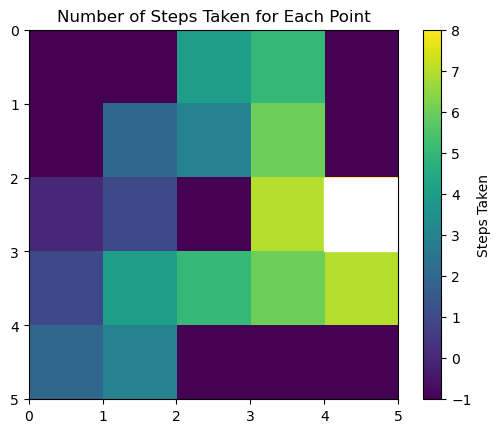

18:01:45.935:aoc2023 - INF: Tests passed!


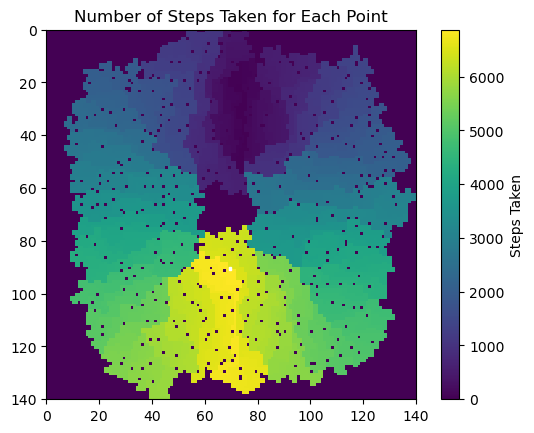

18:01:47.134:aoc2023 - INF: Part 1 soln=6875


CPU times: total: 1.16 s
Wall time: 1.56 s


In [137]:
%%time
sample_inputs = [["..F7.",
                  ".FJ|.",
                  "SJ.L7",
                  "|F--J",
                  "LJ..."]
]
sample_answers = [8]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_grid = parse_grid(curr_input)
    curr_soln, curr_furthest, curr_from = solve_part1(curr_grid)
    validate(curr_soln, curr_ans) # test with sample data

logger.info("Tests passed!")

grid = parse_grid(input_data)
soln, furthest, came_from = solve_part1(grid)
logger.info(f"Part 1 soln={soln}")

### Day 10 Part 2

**How many tiles are enclosed by the loop?**

OMG.

**My first solution**:

- Determine the number of tiles, i.e. ".". Trivial.
- Flood fill (BFS) to find the area of all enclosed ".".
- The tricky part is working out which of these regions is enclosed by our loop.

Ah, it turns out we're not just counting empty tiles.  We need to count tiles that contain pipe as well.  But NOT pipe that's part of the main loop.

In [184]:
def get_tile_regions(grid: PipeGrid) -> list[set]:
    regions = [] # list of sets, where each set is a tile region
    explored = set()
    all_tiles = [point for point in grid.all_points() if grid.value_at_point(point) == "."]
    logger.debug(f"Count all tiles = {len(all_tiles)}")
    
    # now let's BFS each region of tiles
    for tile in all_tiles:
        if tile in explored: # we've seen this before
            continue
        
        frontier = deque()
        frontier.append(tile)
        this_region_explored = set()
        this_region_explored.add(tile)
        explored.add(tile) # add the start tile
        
        # keep going until the frontier is empty; i.e. when we've explored all the valid nodes
        while frontier:   
            current = frontier.popleft()  # pop the first item off the FIFO queue
            
            for neighbour in grid.valid_neighbours(current):
                if neighbour not in explored:
                    frontier.append(neighbour)
                    this_region_explored.add(neighbour)
                    explored.add(neighbour)
                    
        regions.append(this_region_explored)

    return regions

In [185]:
def plot_path(path: list[Point]):
    # Extract x and y values from the path
    x_values = [point.x for point in path]
    y_values = [point.y for point in path]

    # Plot the graph
    plt.plot(x_values, y_values, marker='o', linestyle='-')
    plt.title('Path Plot')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.grid(True)
    plt.show()

In [192]:
def solve_part2(grid: PipeGrid, furthest: Point, came_from: dict[Point, tuple]):
    logger.debug(grid)
    regions = get_tile_regions(grid)
    start = next(point for point in grid.all_points()
            if grid.value_at_point(point) == "S")
    
    # Start from furthest out, and build path in one direction back to start
    path_first_half = []
    current = furthest
    while current != start:
        path_first_half.append(current)
        current = came_from[current][0]
    
    path_first_half.append(start)
    
    # Now we need the second half of the loop
    # Find the other point closest to furthest
    path_second_half = []
    current = next(neighbour for neighbour in furthest.neighbours(include_diagonals=False)
                   if neighbour in came_from and neighbour not in path_first_half)
    while current != start:
        path_second_half.append(current)
        current = came_from[current][0]
    path_second_half.reverse()
    path_second_half.append(furthest)
    
    path = path_first_half + path_second_half
    logger.debug(f"{path=}")
    
    pltp = pltpath.Path([(point.x, point.y) for point in path])
    inside = 0
    # Now let's work out if each region is inside or outside
    # We only need to look at one point from each region
    for region in regions:
        a_point = list(region)[0]
        x = float(a_point.x)
        y = float(a_point.y)
        if pltp.contains_points([(x, y)]): 
            inside += len(region)
    
    logger.debug(f"Inside count={inside}")
    plot_path(path)
    
    return inside

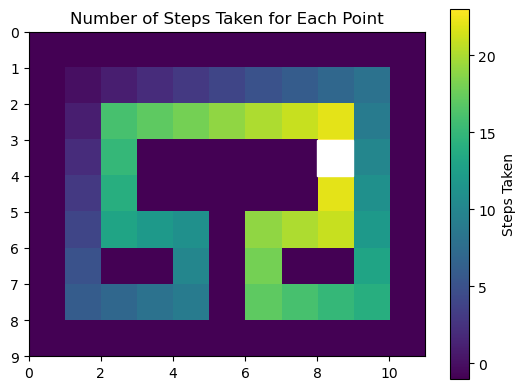

19:25:35.757:aoc2023 - DBG: ...........
.S-------7.
.|F-----7|.
.||.....||.
.||.....||.
.|L-7.F-J|.
.|..|.|..|.
.L--J.L--J.
...........
19:25:35.758:aoc2023 - DBG: Count all tiles = 53
19:25:35.764:aoc2023 - DBG: path=[P(8,3), P(8,4), P(8,5), P(7,5), P(6,5), P(6,6), P(6,7), P(7,7), P(8,7), P(9,7), P(9,6), P(9,5), P(9,4), P(9,3), P(9,2), P(9,1), P(8,1), P(7,1), P(6,1), P(5,1), P(4,1), P(3,1), P(2,1), P(1,1), P(1,2), P(1,3), P(1,4), P(1,5), P(1,6), P(1,7), P(2,7), P(3,7), P(4,7), P(4,6), P(4,5), P(3,5), P(2,5), P(2,4), P(2,3), P(2,2), P(3,2), P(4,2), P(5,2), P(6,2), P(7,2), P(8,2), P(8,3)]
19:25:35.766:aoc2023 - DBG: Inside count=4


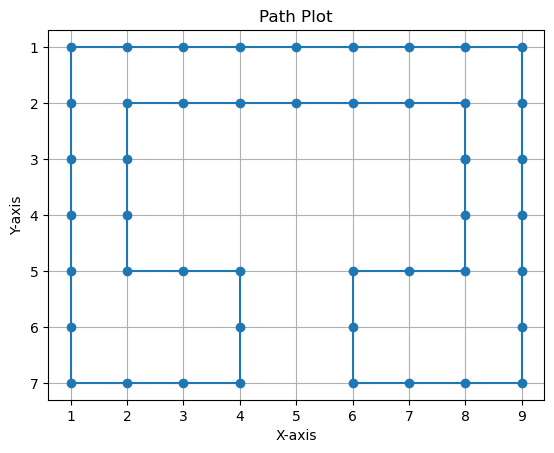

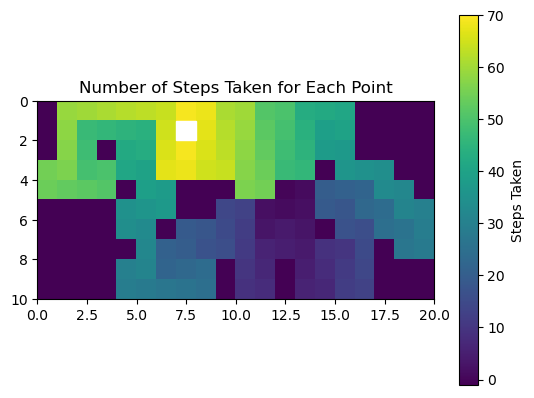

19:25:36.428:aoc2023 - DBG: .F----7F7F7F7F-7....
.|F--7||||||||FJ....
.||.FJ||||||||L7....
FJL7L7LJLJ||LJ.L-7..
L--J.L7...LJS7F-7L7.
....F-J..F7FJ|L7L7L7
....L7.F7||L7|.L7L7|
.....|FJLJ|FJ|F7|.LJ
....FJL-7.||.||||...
....L---J.LJ.LJLJ...
19:25:36.429:aoc2023 - DBG: Count all tiles = 60
19:25:36.435:aoc2023 - DBG: path=[P(7,1), P(7,0), P(8,0), P(8,1), P(8,2), P(8,3), P(9,3), P(9,2), P(9,1), P(9,0), P(10,0), P(10,1), P(10,2), P(10,3), P(10,4), P(11,4), P(11,3), P(11,2), P(11,1), P(11,0), P(12,0), P(12,1), P(12,2), P(12,3), P(13,3), P(13,2), P(13,1), P(13,0), P(14,0), P(15,0), P(15,1), P(14,1), P(14,2), P(15,2), P(15,3), P(16,3), P(17,3), P(17,4), P(18,4), P(18,5), P(19,5), P(19,6), P(19,7), P(18,7), P(18,6), P(17,6), P(17,5), P(16,5), P(16,4), P(15,4), P(14,4), P(14,5), P(15,5), P(15,6), P(16,6), P(16,7), P(16,8), P(16,9), P(15,9), P(15,8), P(15,7), P(14,7), P(14,8), P(14,9), P(13,9), P(13,8), P(13,7), P(13,6), P(13,5), P(13,4), P(12,4), P(12,5), P(11,5), P(11,6), P(12,6), P(12,7), P(11,

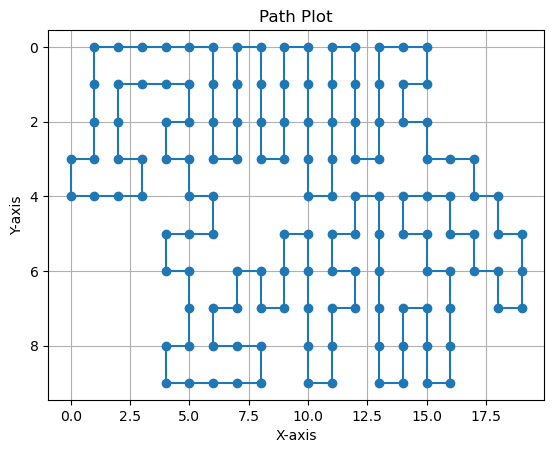

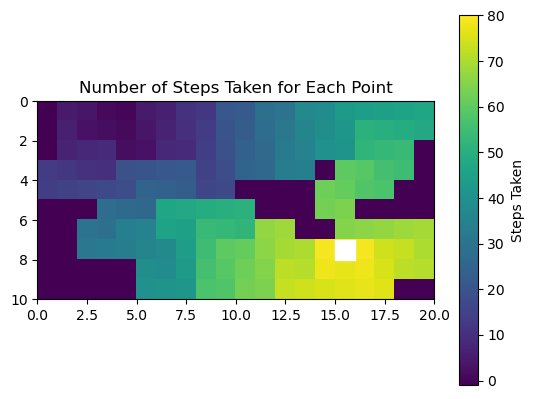

19:25:37.068:aoc2023 - DBG: FF7FSF7F7F7F7F7F---7
L|LJ||||||||||||F--J
FL-7LJLJ||||||LJL-77
F--JF--7||LJLJ7F7FJ-
L---JF-JLJ.||-FJLJJ7
|F|F-JF---7F7-L7L|7|
|FFJF7L7F-JF7|JL---7
7-L-JL7||F7|L7F-7F7|
L.L7LFJ|||||FJL7||LJ
L7JLJL-JLJLJL--JLJ.L
19:25:37.069:aoc2023 - DBG: Count all tiles = 3
19:25:37.071:aoc2023 - DBG: path=[P(15,7), P(16,7), P(16,8), P(16,9), P(17,9), P(17,8), P(17,7), P(18,7), P(18,8), P(19,8), P(19,7), P(19,6), P(18,6), P(17,6), P(16,6), P(15,6), P(15,5), P(14,5), P(14,4), P(15,4), P(15,3), P(16,3), P(16,4), P(17,4), P(17,3), P(18,3), P(18,2), P(17,2), P(16,2), P(16,1), P(17,1), P(18,1), P(19,1), P(19,0), P(18,0), P(17,0), P(16,0), P(15,0), P(15,1), P(15,2), P(14,2), P(14,1), P(14,0), P(13,0), P(13,1), P(13,2), P(13,3), P(12,3), P(12,2), P(12,1), P(12,0), P(11,0), P(11,1), P(11,2), P(11,3), P(10,3), P(10,2), P(10,1), P(10,0), P(9,0), P(9,1), P(9,2), P(9,3), P(9,4), P(8,4), P(8,3), P(8,2), P(8,1), P(8,0), P(7,0), P(7,1), P(7,2), P(6,2), P(6,1), P(6,0), P(5,0), P(5,1), P(5,2

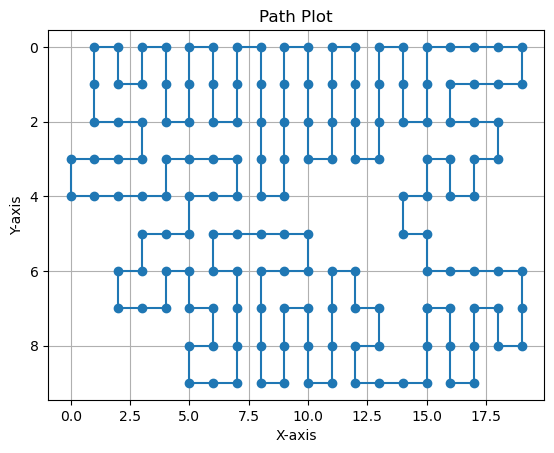

AssertionError: 1 != 10

In [195]:
%%time
sample_1 = """...........
.S-------7.
.|F-----7|.
.||.....||.
.||.....||.
.|L-7.F-J|.
.|..|.|..|.
.L--J.L--J.
..........."""

sample_2 = """.F----7F7F7F7F-7....
.|F--7||||||||FJ....
.||.FJ||||||||L7....
FJL7L7LJLJ||LJ.L-7..
L--J.L7...LJS7F-7L7.
....F-J..F7FJ|L7L7L7
....L7.F7||L7|.L7L7|
.....|FJLJ|FJ|F7|.LJ
....FJL-7.||.||||...
....L---J.LJ.LJLJ...
"""

sample_3 = """FF7FSF7F7F7F7F7F---7
L|LJ||||||||||||F--J
FL-7LJLJ||||||LJL-77
F--JF--7||LJLJ7F7FJ-
L---JF-JLJ.||-FJLJJ7
|F|F-JF---7F7-L7L|7|
|FFJF7L7F-JF7|JL---7
7-L-JL7||F7|L7F-7F7|
L.L7LFJ|||||FJL7||LJ
L7JLJL-JLJLJL--JLJ.L
"""

sample_inputs = [sample_1.splitlines(), 
                 sample_2.splitlines(),
                 sample_3.splitlines()]
sample_answers = [4, 8, 10]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    curr_grid = parse_grid(curr_input)
    curr_pt1_soln, curr_furthest, curr_from = solve_part1(curr_grid)
    curr_pt2_soln = solve_part2(curr_grid, curr_furthest, curr_from)
    validate(curr_pt2_soln, curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(grid, furthest, came_from)
logger.info(f"Part 2 soln={soln}")

---
## Day n: title

In [ ]:
DAY = "n" # replace with actual number (without leading digit)
logger.setLevel(logging.DEBUG)
day_link = f"#### See [Day {DAY}](https://adventofcode.com/{YEAR}/day/{DAY})."
display(Markdown(day_link))

In [ ]:
d_name = "d" + str(DAY).zfill(2) # e.g. d01
script_name = "aoc" + str(YEAR) + d_name # e.g. aoc2017d01
locations = get_locations(d_name)

# SETUP LOGGING
logger.setLevel(logging.DEBUG)
# td.setup_file_logging(logger, locations.output_dir)

# Retrieve input and store in local file
try:
    write_puzzle_input_file(YEAR, DAY, locations)
    with open(locations.input_file, mode="rt") as f:
        input_data = f.read().splitlines()

    logger.info("Input data:\n%s", top_and_tail(input_data))
except ValueError as e:
    logger.error(e)

### Day n Part 1

Overview...

In [ ]:
def solve(data):
    pass

In [ ]:
%%time
sample_inputs = ["abcdef"]
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part1(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part1(input_data)
logger.info(f"Part 1 soln={soln}")

### Day n Part 2

Overview...

In [ ]:
def solve_part2(data):
    pass

In [ ]:
%%time
sample_inputs = ["abcdef"]
sample_answers = ["uvwxyz"]

for curr_input, curr_ans in zip(sample_inputs, sample_answers):
    validate(solve_part2(curr_input), curr_ans) # test with sample data

logger.info("Tests passed!")

soln = solve_part2(input_data)
logger.info(f"Part 2 soln={soln}")